In [1]:
import keras
from keras.models import Sequential, Model, load_model

from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, BatchNormalization, LocallyConnected2D, Permute
from keras.layers import Concatenate, Reshape, Softmax, Conv2DTranspose, Embedding, Multiply
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras import regularizers
from keras import backend as K
import keras.losses

import tensorflow as tf
from tensorflow.python.framework import ops

import isolearn.keras as iso

import numpy as np

import tensorflow as tf
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

import pandas as pd

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

import isolearn.io as isoio
import isolearn.keras as isol

from genesis.visualization import *
from genesis.generator import *
from genesis.predictor import *
from genesis.optimizer import *

from definitions.generator.aparent_deconv_conv_generator_concat_alllayers import load_generator_network
from definitions.predictor.aparent import load_saved_predictor

import sklearn

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


Using TensorFlow backend.


In [2]:

#Define target isoform loss function
def get_cleavage_loss(target_poses, use_start=0, use_end=70, use_target_bits=1.8, cse_start=70, cse_end=76, cse_target_bits=1.8, dse_start=76, dse_end=125, dse_target_bits=1.8, entropy_weight=0.0, similarity_weight=0.0, punish_dn_cse=0.0, punish_up_c=0.0, punish_dn_c=0.0, reward_dn_ggcc=0.0, punish_up_aa=0.0, punish_dn_aa=0.0) :
    
    target_cuts = np.zeros((len(target_poses), 206))
    for i, target_pos in enumerate(target_poses) :
        target_cuts[i, target_pos] = 1.0
    
    masked_use_entropy_mse = get_target_entropy_sme_masked(pwm_start=use_start, pwm_end=use_end, target_bits=use_target_bits)
    cse_entropy_mse = get_target_entropy_sme(pwm_start=cse_start, pwm_end=cse_end, target_bits=cse_target_bits)
    masked_dse_entropy_mse = get_target_entropy_sme_masked(pwm_start=dse_start, pwm_end=dse_end, target_bits=dse_target_bits)
    
    punish_dn_cse_func = get_punish_cse(pwm_start=74, pwm_end=dse_end)
    
    punish_up_c_func = get_punish_c(pwm_start=use_start, pwm_end=use_end)
    punish_dn_c_func = get_punish_c(pwm_start=dse_start, pwm_end=dse_end)
    
    punish_dn_gg_func = get_punish_gg(pwm_start=80, pwm_end=110)
    punish_dn_cc_func = get_punish_cc(pwm_start=80, pwm_end=110)
    
    punish_up_aa_func = get_punish_aa(pwm_start=use_start, pwm_end=use_end)
    punish_dn_aa_func = get_punish_aa(pwm_start=dse_start, pwm_end=dse_end)
    
    pwm_sample_entropy_func = get_pwm_margin_sample_entropy_masked(pwm_start=70-60, pwm_end=76+60, margin=0.5, shift_1_nt=True)
    #pwm_sample_entropy_func = get_pwm_sample_entropy_masked(pwm_start=70-60, pwm_end=76+60)
    
    #pwm_sample_entropy_up_func = get_pwm_margin_sample_entropy_masked(pwm_start=70-60, pwm_end=70-4, margin=0.5, shift_1_nt=True)
    #pwm_sample_entropy_dn_func = get_pwm_margin_sample_entropy_masked(pwm_start=76, pwm_end=76+60, margin=0.5, shift_1_nt=True)
    
    extra_sim = np.ones((len(target_poses), 1, 205, 4, 1))
    for i in range(len(target_poses)) :
        extra_sim[i, 0, 70-4:76, :, 0] = 0.0
    
    def loss_func(loss_tensors) :
        _, _, _, sequence_class, pwm_logits_1, pwm_logits_2, pwm_1, pwm_2, sampled_pwm_1, sampled_pwm_2, mask, sampled_mask, iso_pred, cut_pred, iso_score_pred, cut_score_pred = loss_tensors
        
        #Create target cuts with sample axis (ax=1)
        cut_targets = K.constant(target_cuts)
        cut_true = K.gather(cut_targets, sequence_class[:, 0])
        cut_true = K.tile(K.expand_dims(cut_true, axis=1), (1, K.shape(sampled_pwm_1)[1], 1))
        
        #Specify costs
        cut_loss = 1.0 * K.mean(kl_divergence(cut_true, cut_pred), axis=1)
        
        seq_loss = 0.0
        seq_loss += punish_dn_cse * K.mean(punish_dn_cse_func(sampled_pwm_1), axis=1)
        
        seq_loss += punish_up_c * K.mean(punish_up_c_func(sampled_pwm_1), axis=1)
        seq_loss += punish_dn_c * K.mean(punish_dn_c_func(sampled_pwm_1), axis=1)
        
        seq_loss += punish_up_aa * K.mean(punish_up_aa_func(sampled_pwm_1), axis=1)
        seq_loss += punish_dn_aa * K.mean(punish_dn_aa_func(sampled_pwm_1), axis=1)
        
        seq_loss += reward_dn_ggcc * (-1.) * punish_dn_gg_func(pwm_1) * punish_dn_cc_func(pwm_1)
        
        
        extra_sims = K.constant(extra_sim)
        extra_sim_mask = K.gather(extra_sims, sequence_class[:, 0])
        extra_sim_mask = K.tile(extra_sim_mask, (1, K.shape(sampled_pwm_1)[1], 1, 1, 1))
        
        entropy_loss = entropy_weight * (masked_use_entropy_mse(pwm_1, mask) + cse_entropy_mse(pwm_1) + masked_dse_entropy_mse(pwm_1, mask))
        entropy_loss += similarity_weight * K.mean(pwm_sample_entropy_func(sampled_pwm_1, sampled_pwm_2, sampled_mask * extra_sim_mask), axis=1)
        #entropy_loss += similarity_weight * K.mean(pwm_sample_entropy_up_func(sampled_pwm_1, sampled_pwm_2, sampled_mask), axis=1) / 2.0
        #entropy_loss += similarity_weight * K.mean(pwm_sample_entropy_dn_func(sampled_pwm_1, sampled_pwm_2, sampled_mask), axis=1) / 2.0
        
        
        #Compute total loss
        total_loss = cut_loss + seq_loss + entropy_loss

        return total_loss
    
    return loss_func

class EpochVariableCallback(Callback):
    def __init__(self, my_variable, my_func):
        self.my_variable = my_variable       
        self.my_func = my_func
    def on_epoch_end(self, epoch, logs={}):
        K.set_value(self.my_variable, self.my_func(K.get_value(self.my_variable), epoch))

#Function for running GENESIS
def run_genesis(sequence_templates, loss_func, library_contexts, model_path, batch_size=32, n_samples=1, n_epochs=10, steps_per_epoch=100) :
    
    #Build Generator Network
    _, generator = build_generator(batch_size, len(sequence_templates[0]), load_generator_network, n_classes=len(sequence_templates), n_samples=n_samples, sequence_templates=sequence_templates, batch_normalize_pwm=False)

    #Build Predictor Network and hook it on the generator PWM output tensor
    _, pwm_predictor = build_predictor(generator, load_saved_predictor(model_path, library_contexts=library_contexts), batch_size, n_samples=1, eval_mode='pwm')
    _, sample_predictor = build_predictor(generator, load_saved_predictor(model_path, library_contexts=library_contexts), batch_size, n_samples=n_samples, eval_mode='sample')

    for layer in pwm_predictor.layers :
        if 'aparent' in layer.name :
            layer.name += "_pwmversion"
    
    #Build Loss Model (In: Generator seed, Out: Loss function)
    _, pwm_loss_model = build_loss_model(pwm_predictor, loss_func)
    _, sample_loss_model = build_loss_model(sample_predictor, loss_func)
    
    dual_loss_out = Lambda(lambda x: 0.5 * x[0] + 0.5 * x[1])([pwm_loss_model.outputs[0], sample_loss_model.outputs[0]])

    loss_model = Model(inputs=pwm_loss_model.inputs, outputs=dual_loss_out)
    
    #Specify Optimizer to use
    #opt = keras.optimizers.SGD(lr=0.1)
    opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

    #Compile Loss Model (Minimize self)
    loss_model.compile(loss=lambda true, pred: pred, optimizer=opt)

    #Fit Loss Model
    train_history = loss_model.fit(
        [], np.ones((1, 1)), #Dummy training example
        epochs=n_epochs,
        steps_per_epoch=steps_per_epoch
    )

    return generator, sample_predictor, train_history



In [3]:
#Specfiy file path to pre-trained predictor network

save_dir = os.path.join(os.getcwd(), '../../../aparent/saved_models')
saved_predictor_model_name = 'aparent_plasmid_iso_cut_distalpas_all_libs_no_sampleweights_sgd.h5'
saved_predictor_model_path = os.path.join(save_dir, saved_predictor_model_name)

In [4]:
#Maximize isoform proportions for all native minigene libraries

sequence_templates = [
    'CCCTACACGACGCTCTTCCGATCTNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNAATAAANNNNNATNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNGTGTCCTGCCCGGTCGGCTTGAGCGCGTGGGTCTCGTTTAGATGCTGCGCCTAACCCTAAGCAGATTCTTCATGCAATTGT',
    'CCCTACACGACGCTCTTCCGATCTNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNAATAAANNNNNNNNNNATNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNGTGTCCTGCCCGGTCGGCTTGAGCGCGTGGGTCTCGTTTAGATGCTGCGCCTAACCCTAAGCAGATTCTTCATGCAATTGT',
    'CCCTACACGACGCTCTTCCGATCTNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNAATAAANNNNNNNNNNNNNNNATNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNGTGTCCTGCCCGGTCGGCTTGAGCGCGTGGGTCTCGTTTAGATGCTGCGCCTAACCCTAAGCAGATTCTTCATGCAATTGT',
    'CCCTACACGACGCTCTTCCGATCTNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNAATAAANNNNNNNNNNNNNNNNNNNNATNNNNNNNNNNNNNNNNNNNNNNNNNNNGTGTCCTGCCCGGTCGGCTTGAGCGCGTGGGTCTCGTTTAGATGCTGCGCCTAACCCTAAGCAGATTCTTCATGCAATTGT',
    'CCCTACACGACGCTCTTCCGATCTNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNAATAAANNNNNNNNNNNNNNNNNNNNNNNNNATNNNNNNNNNNNNNNNNNNNNNNGTGTCCTGCCCGGTCGGCTTGAGCGCGTGGGTCTCGTTTAGATGCTGCGCCTAACCCTAAGCAGATTCTTCATGCAATTGT',
    'CCCTACACGACGCTCTTCCGATCTNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNAATAAANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNATNNNNNNNNNNNNNNNNNGTGTCCTGCCCGGTCGGCTTGAGCGCGTGGGTCTCGTTTAGATGCTGCGCCTAACCCTAAGCAGATTCTTCATGCAATTGT',
    'CCCTACACGACGCTCTTCCGATCTNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNAATAAANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNATNNNNNNNNNNNNGTGTCCTGCCCGGTCGGCTTGAGCGCGTGGGTCTCGTTTAGATGCTGCGCCTAACCCTAAGCAGATTCTTCATGCAATTGT',
    'CCCTACACGACGCTCTTCCGATCTNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNAATAAANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNATNNNNNNNGTGTCCTGCCCGGTCGGCTTGAGCGCGTGGGTCTCGTTTAGATGCTGCGCCTAACCCTAAGCAGATTCTTCATGCAATTGT',
    'CCCTACACGACGCTCTTCCGATCTNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNAATAAANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNATNNGTGTCCTGCCCGGTCGGCTTGAGCGCGTGGGTCTCGTTTAGATGCTGCGCCTAACCCTAAGCAGATTCTTCATGCAATTGT'
]


library_contexts = [
    'simple',
    'simple',
    'simple',
    'simple',
    'simple',
    'simple',
    'simple',
    'simple',
    'simple'
]

cut_positions = [
    80,
    85,
    90,
    95,
    100,
    105,
    110,
    115,
    120
]



In [5]:
#Train APA Cleavage GENESIS Network

print("Training GENESIS (multi-class)")

#Number of PWMs to generate per objective
batch_size = 36
#Number of One-hot sequences to sample from the PWM at each grad step
n_samples = 10
#Number of epochs per objective to optimize
n_epochs = 50
#Number of steps (grad updates) per epoch
steps_per_epoch = 500

loss = get_cleavage_loss(
    cut_positions,
    use_start=22,
    use_end=70,
    use_target_bits=1.95,
    cse_start=70,
    cse_end=76,
    cse_target_bits=1.95,
    dse_start=76,
    dse_end=125,
    dse_target_bits=1.95,
    entropy_weight=1.0,
    similarity_weight=5.0,
    punish_dn_cse=1.0,
    punish_up_c=0.007,
    punish_dn_c=0.010,
    reward_dn_ggcc=0.0,
    punish_up_aa=0.0,
    punish_dn_aa=0.025
)


genesis_generator, genesis_predictor, train_history = run_genesis(sequence_templates, loss, library_contexts, saved_predictor_model_path, batch_size, n_samples, n_epochs, steps_per_epoch)

genesis_generator.get_layer('lambda_rand_sequence_class').function = lambda inp: inp
genesis_generator.get_layer('lambda_rand_input_1').function = lambda inp: inp
genesis_generator.get_layer('lambda_rand_input_2').function = lambda inp: inp

genesis_predictor.get_layer('lambda_rand_sequence_class').function = lambda inp: inp
genesis_predictor.get_layer('lambda_rand_input_1').function = lambda inp: inp
genesis_predictor.get_layer('lambda_rand_input_2').function = lambda inp: inp

# Save model and weights
save_dir = 'saved_models'

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

model_name = 'genesis_cleavage_pwm_and_multisample_marginsimilarity_hardersimilarity_simple_sym_kl_concat_retry_1_generator.h5'
model_path = os.path.join(save_dir, model_name)
genesis_generator.save(model_path)
print('Saved trained model at %s ' % model_path)

model_name = 'genesis_cleavage_pwm_and_multisample_marginsimilarity_hardersimilarity_simple_sym_kl_concat_retry_1_predictor.h5'
model_path = os.path.join(save_dir, model_name)
genesis_predictor.save(model_path)
print('Saved trained model at %s ' % model_path)


Training GENESIS (multi-class)


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Epoch 1/50
500/500 [==============================] - 52s 103ms/step - loss: 1.4310
Epoch 2/50
500/500 [==============================] - 46s 91ms/step - loss: 0.7629
Epoch 3/50
500/500 [==============================] - 46s 92ms/step - loss: 0.6554
Epoch 4/50
500/500 [==============================] - 46s 92ms/step - loss: 0.6108
Epoch 5/50
500/500 [==============================] - 46s 92ms/step - loss: 0.5951
Epoch 6/50
500/500 [==============================] - 46s 92ms/step - loss: 0.5700
Epoch 7/50
500/500 [==============================] - 46s 92ms/step - loss: 0.5618
Epoch 8/50
500/500 [==============================] - 46s 92ms/step - loss: 0.5458
Epoch 9/50
500/500 [==============================] - 46s 92ms/step - loss: 0.5316
Epoch 10/50
500/500 [==============================] - 46s 92ms/step - loss: 0.5167
Epoch 11/50
500/500 [==============================] - 46s 92ms/step - loss: 0.5141
Epoch 12/50
500/500 [==============================] - 46s 92ms/step - loss: 0.5107


In [4]:
#(Re-)Load GENESIS model

save_dir = os.path.join(os.getcwd(), 'saved_models/target_cleavage')
model_name = 'genesis_cleavage_pwm_and_multisample_marginsimilarity_hardersimilarity_simple_sym_kl_concat_retry_1_generator.h5'
model_path = os.path.join(save_dir, model_name)

generator = load_model(model_path, custom_objects={'st_sampled_softmax': st_sampled_softmax, 'st_hardmax_softmax': st_hardmax_softmax})

save_dir = os.path.join(os.getcwd(), 'saved_models/target_cleavage')
model_name = 'genesis_cleavage_pwm_and_multisample_marginsimilarity_hardersimilarity_simple_sym_kl_concat_retry_1_predictor.h5'
model_path = os.path.join(save_dir, model_name)

predictor = load_model(model_path, custom_objects={'st_sampled_softmax': st_sampled_softmax, 'st_hardmax_softmax': st_hardmax_softmax})


/home/jlinder2/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [5]:
n = 36 * 6

sequence_class = np.array([j for i in [[k] * 20 for k in range(9)] for j in i] + [0] * 200)[:n].reshape(-1, 1)

noise_1 = np.random.uniform(-1, 1, (n, 100))
noise_2 = np.random.uniform(-1, 1, (n, 100))

pred_outputs = predictor.predict([sequence_class, noise_1, noise_2], batch_size=36)

_, _, _, optimized_pwm, _, _, _, _, _, iso_pred, cut_pred, _, _ = pred_outputs


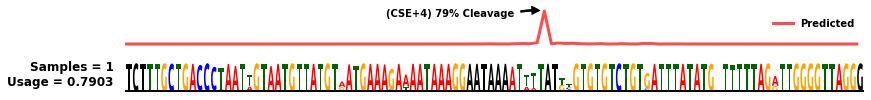

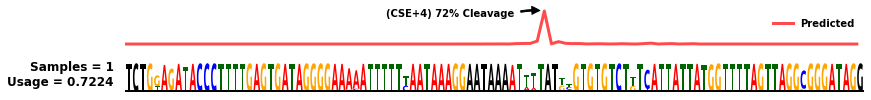

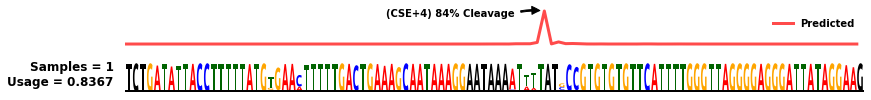

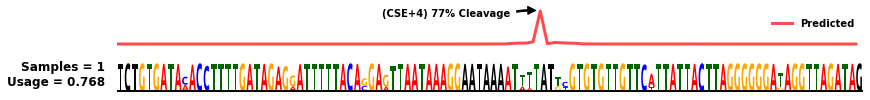

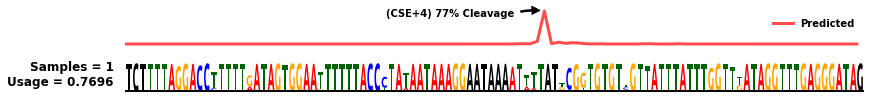

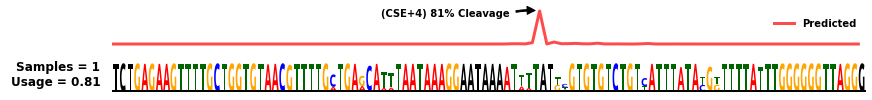

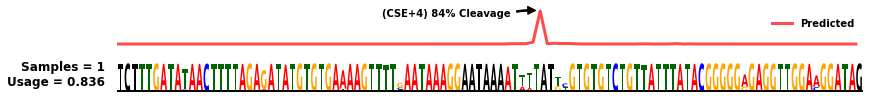

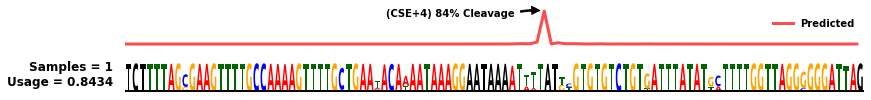

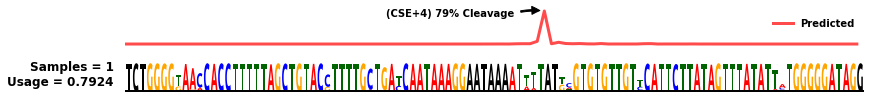

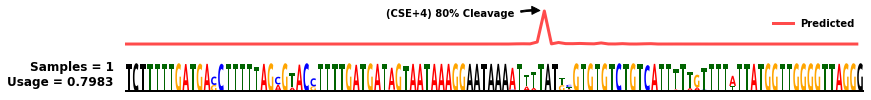

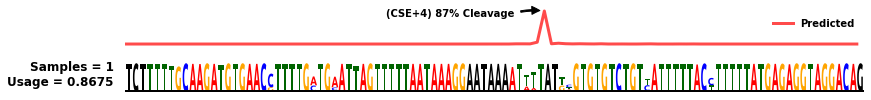

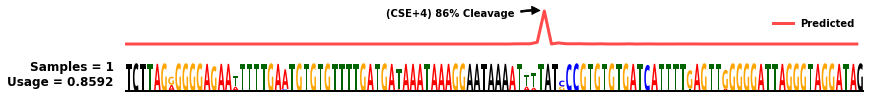

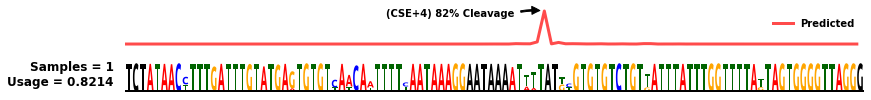

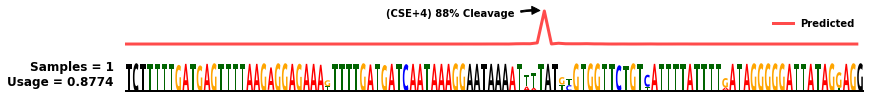

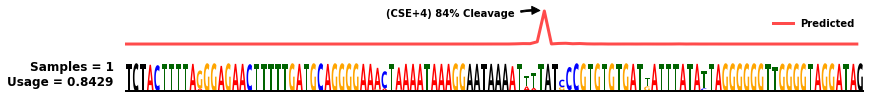

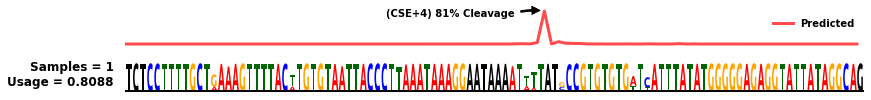

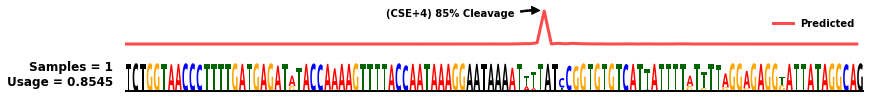

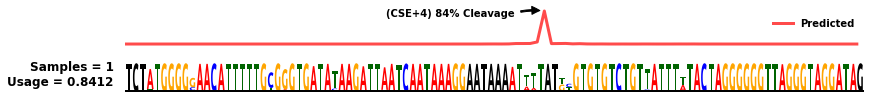

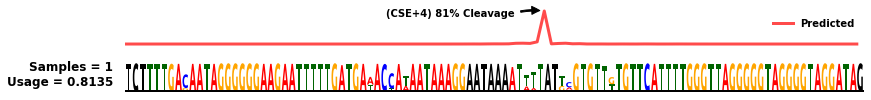

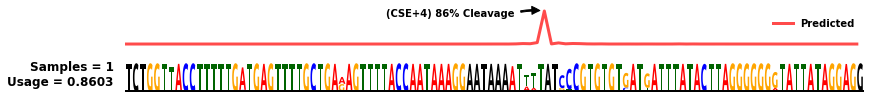

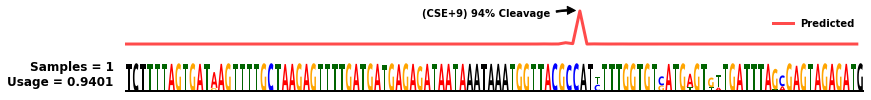

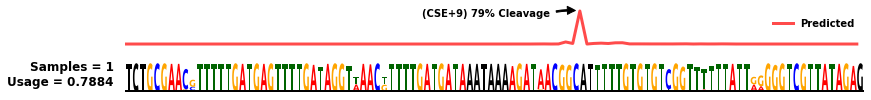

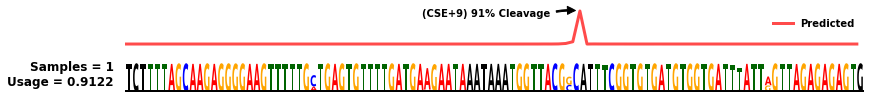

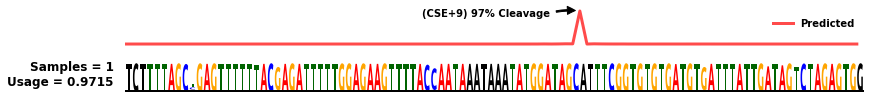

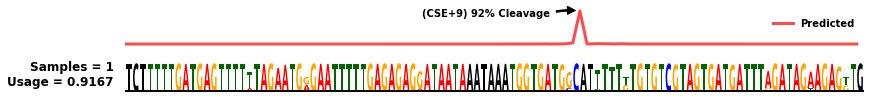

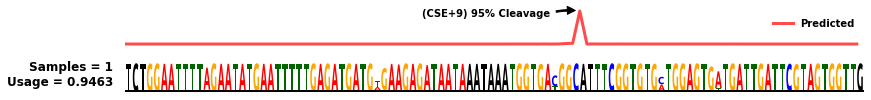

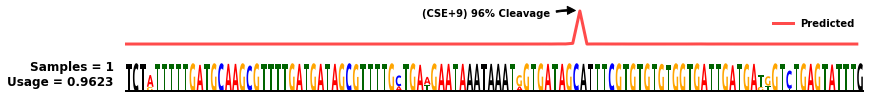

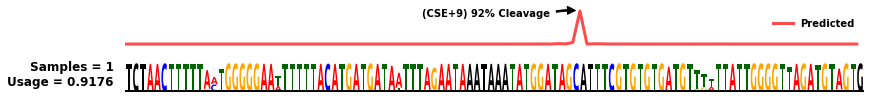

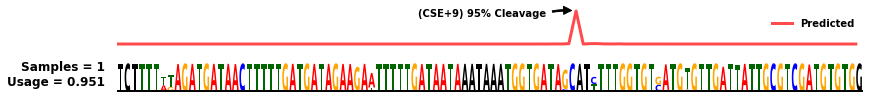

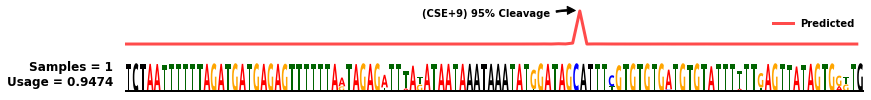

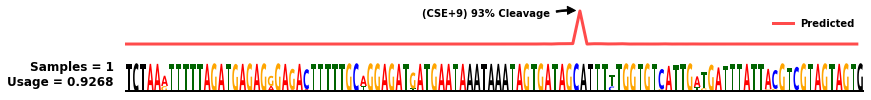

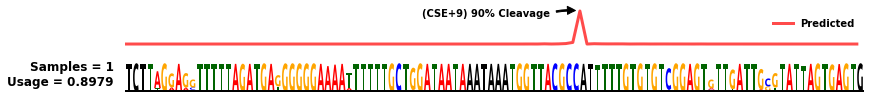

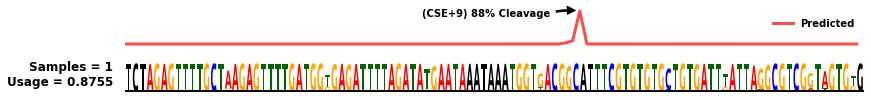

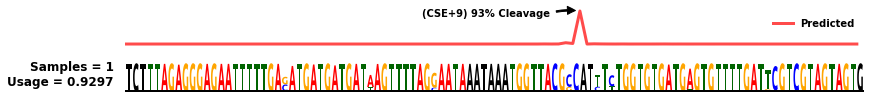

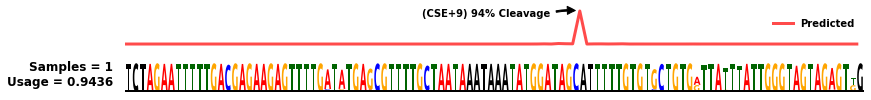

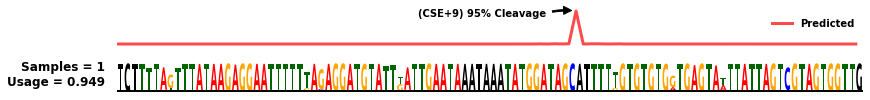

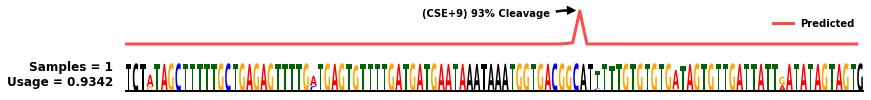

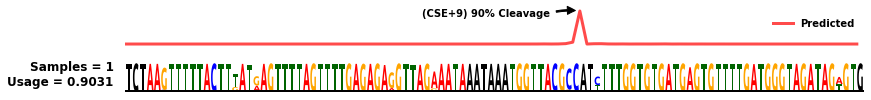

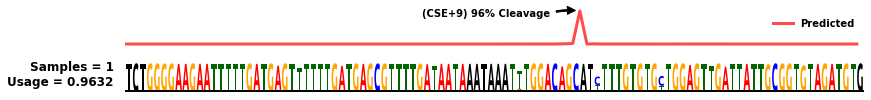

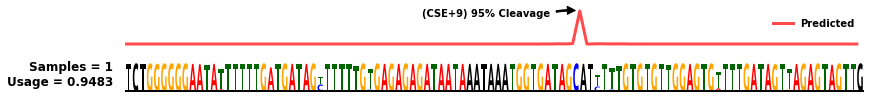

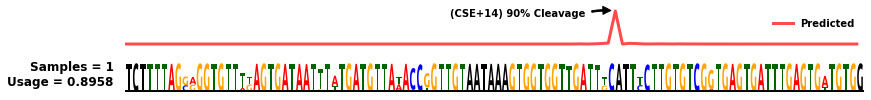

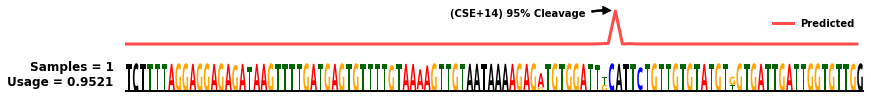

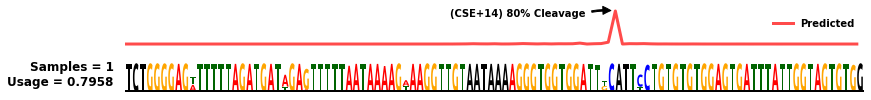

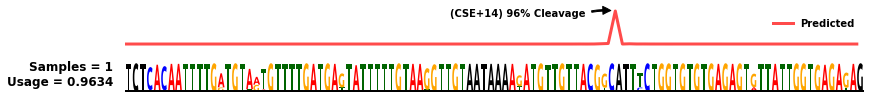

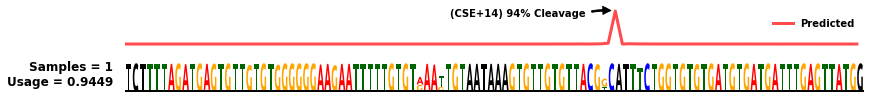

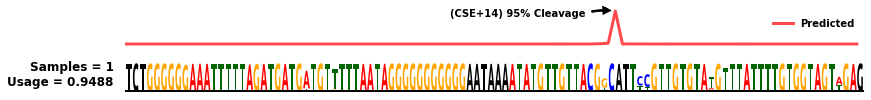

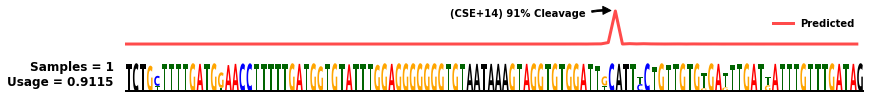

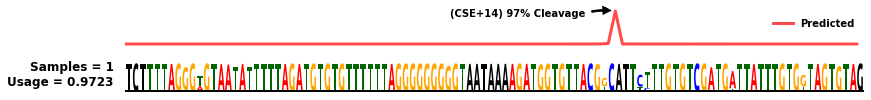

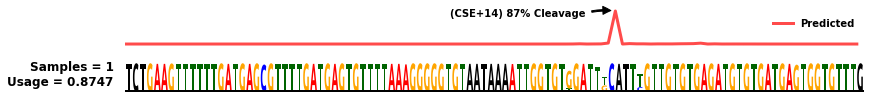

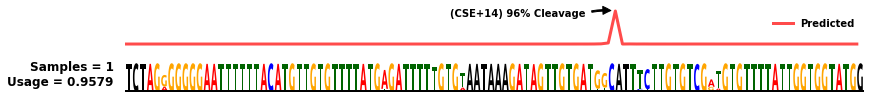

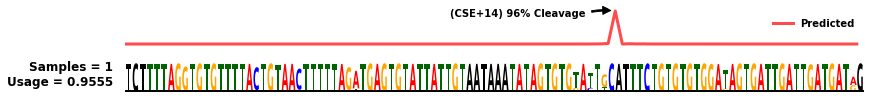

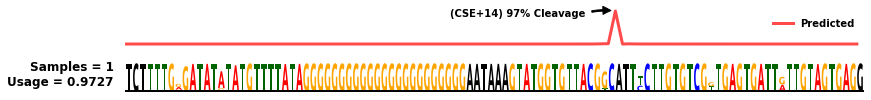

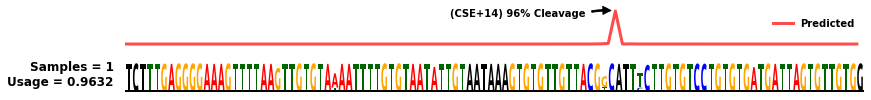

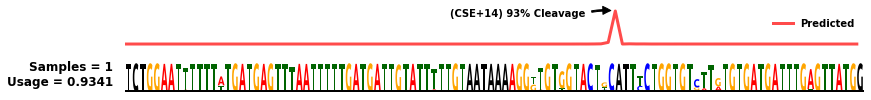

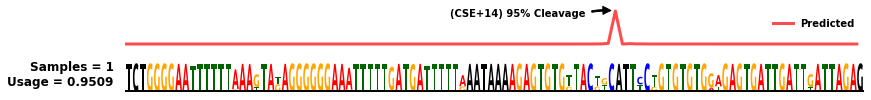

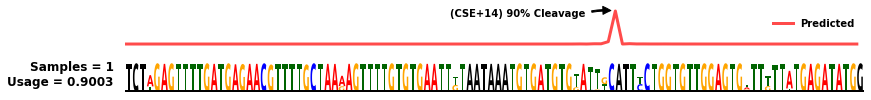

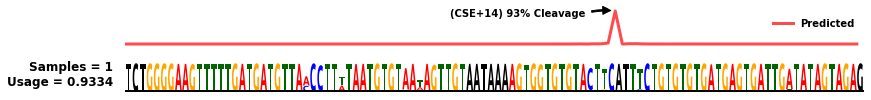

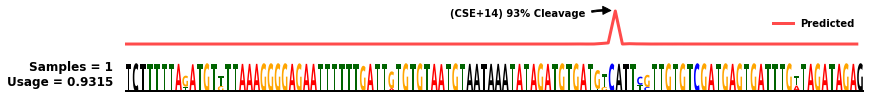

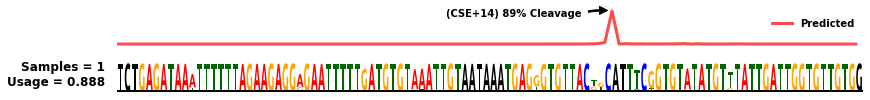

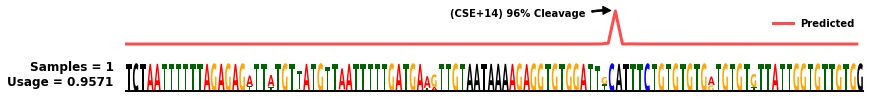

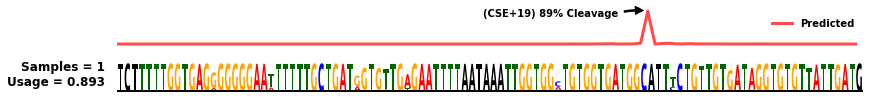

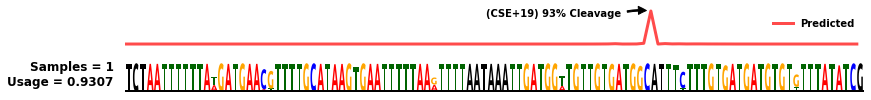

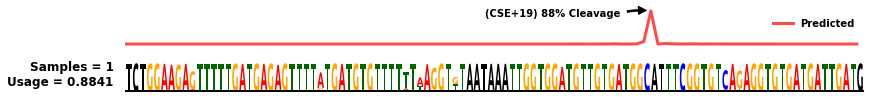

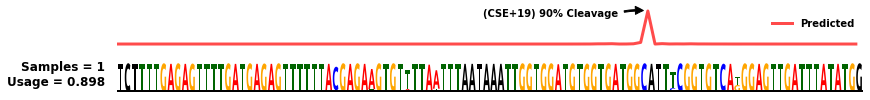

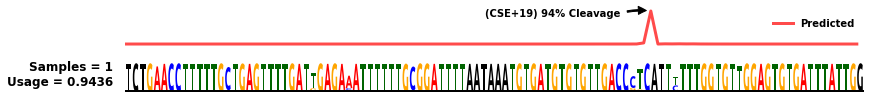

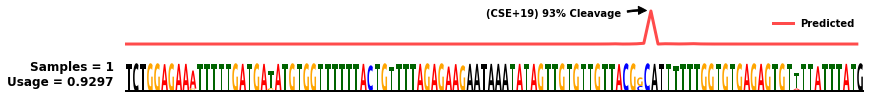

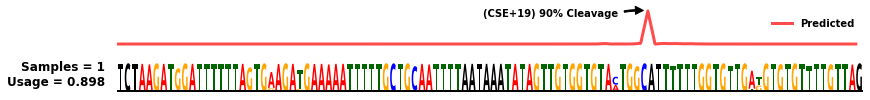

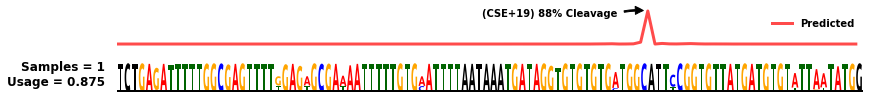

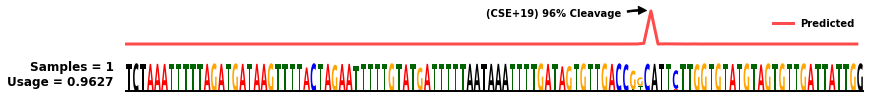

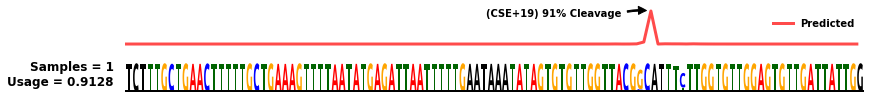

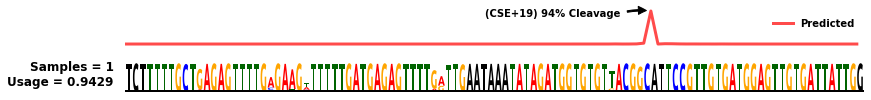

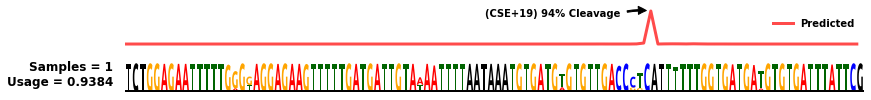

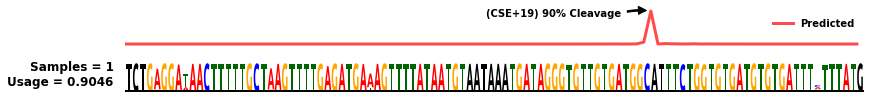

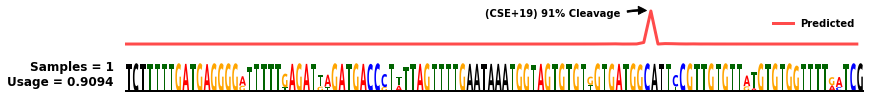

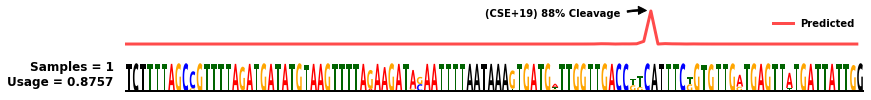

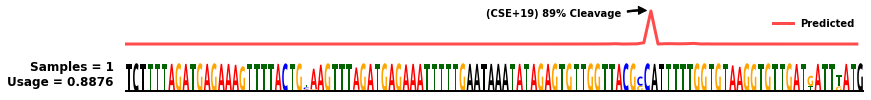

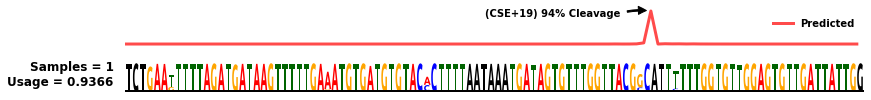

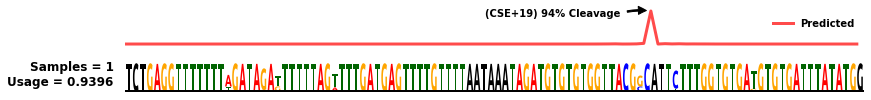

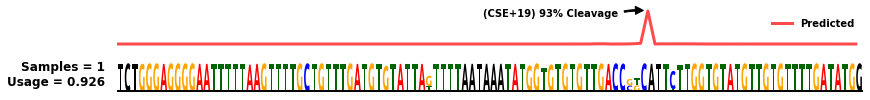

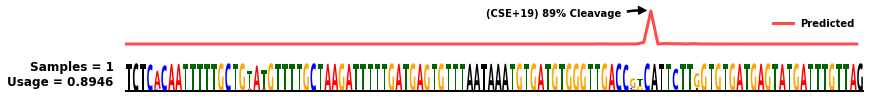

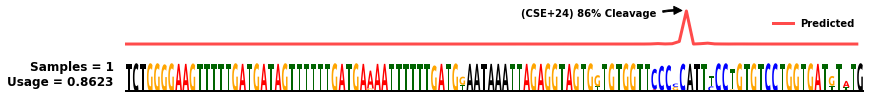

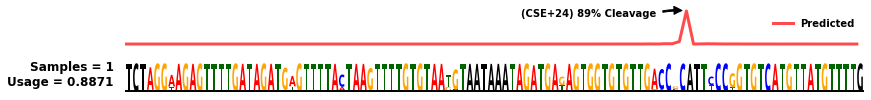

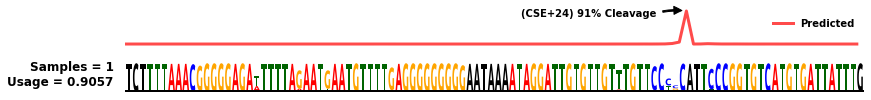

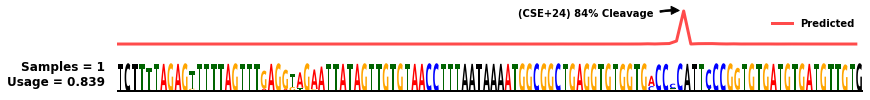

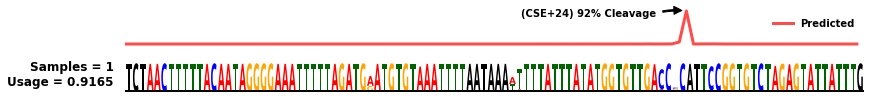

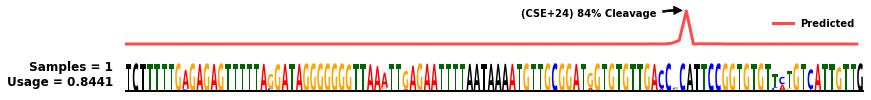

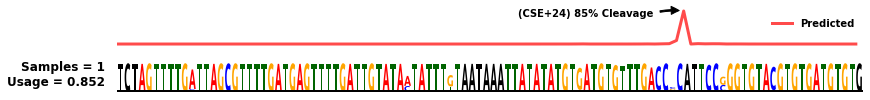

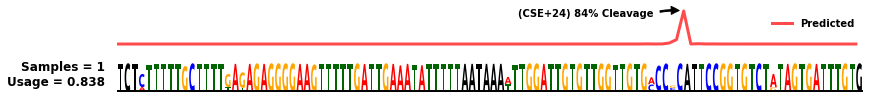

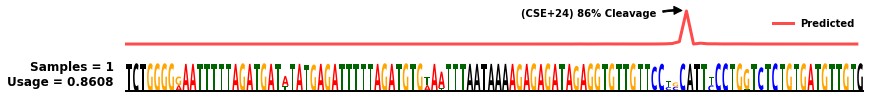

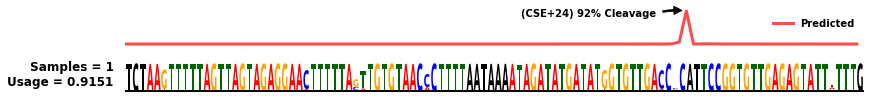

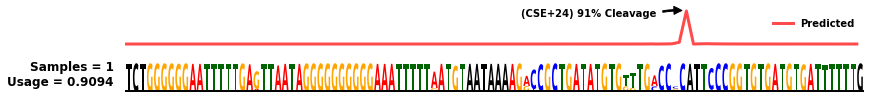

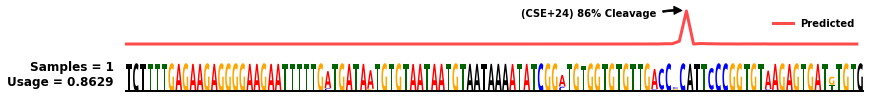

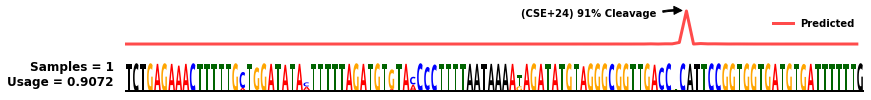

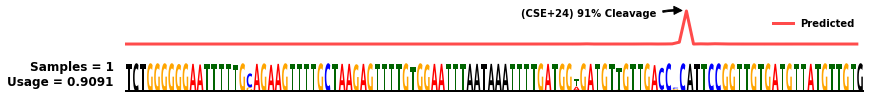

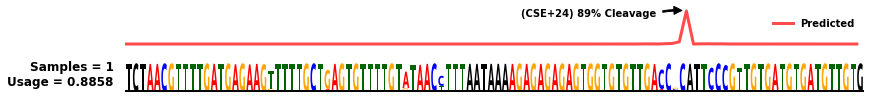

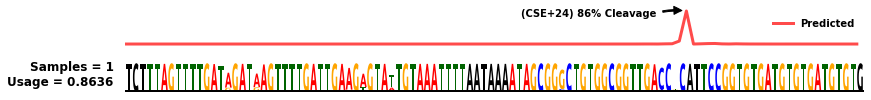

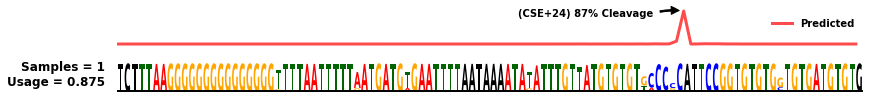

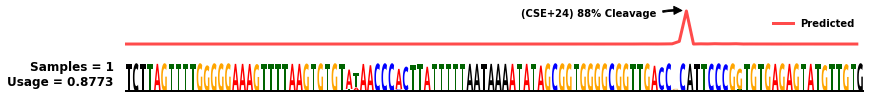

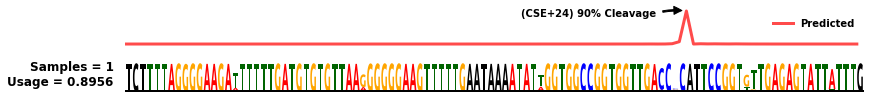

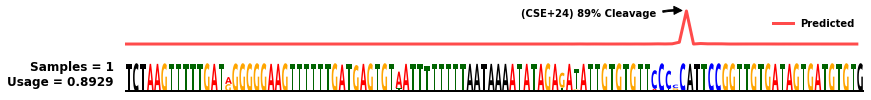

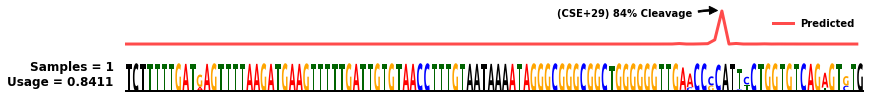

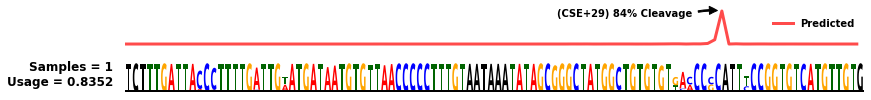

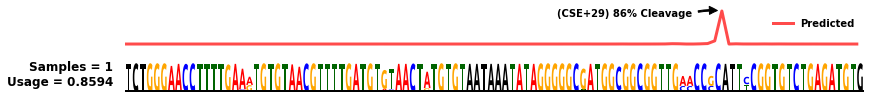

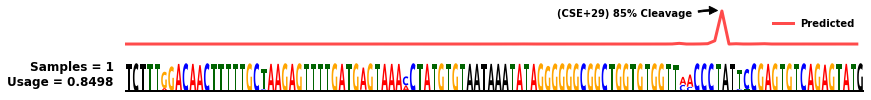

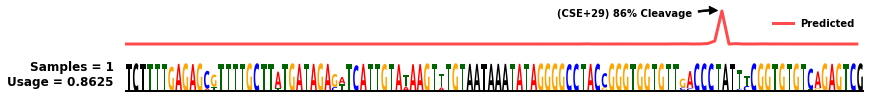

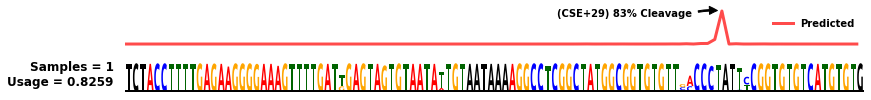

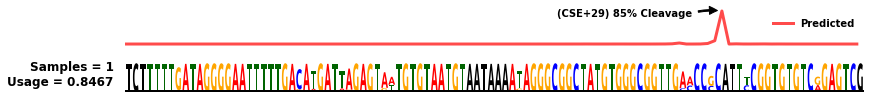

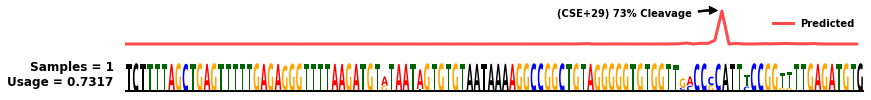

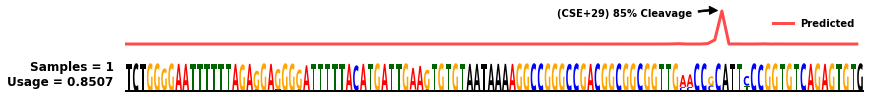

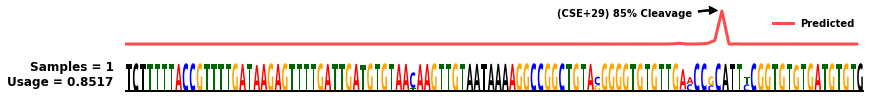

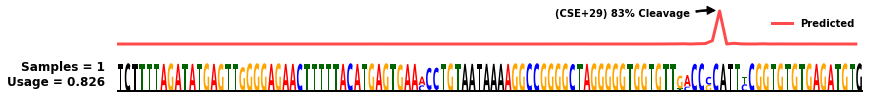

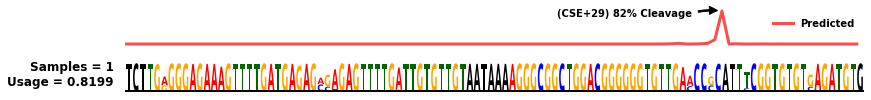

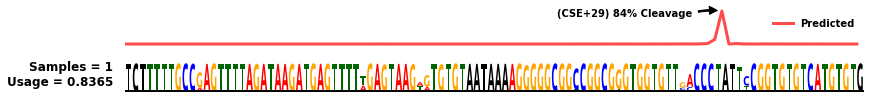

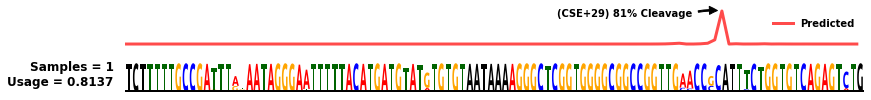

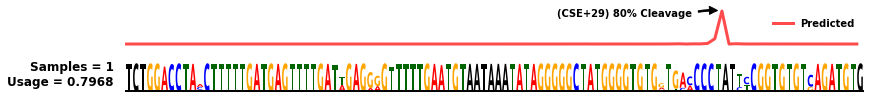

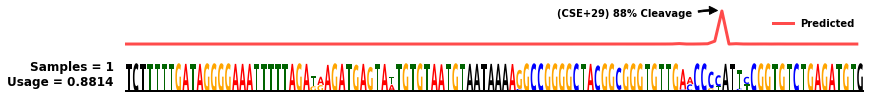

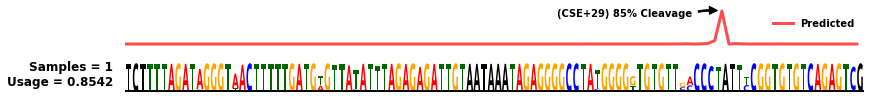

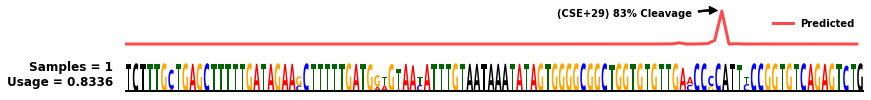

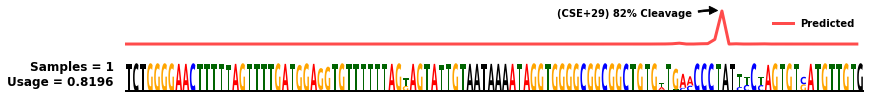

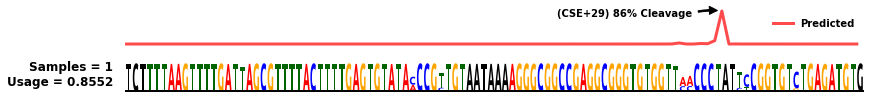

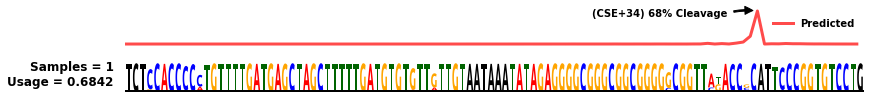

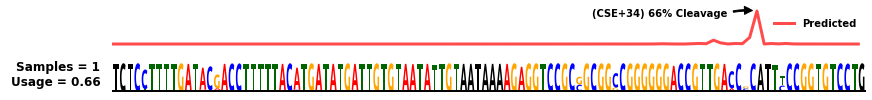

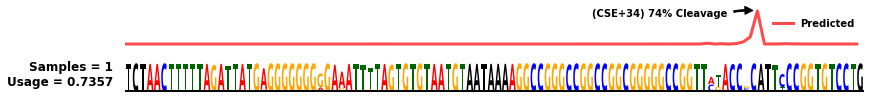

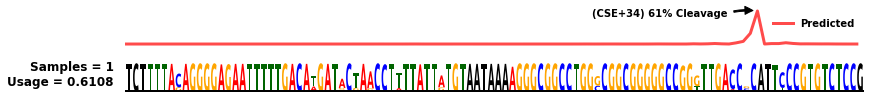

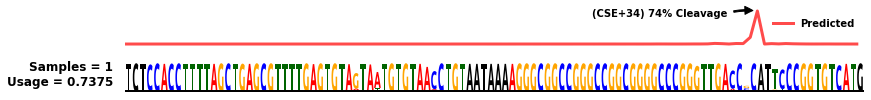

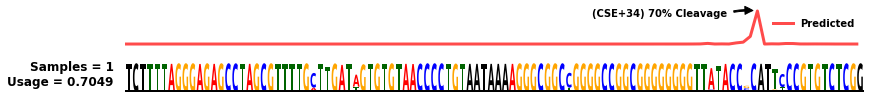

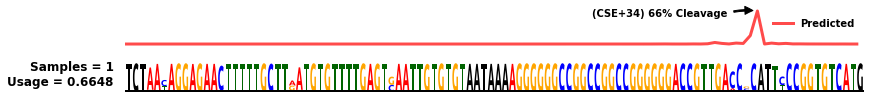

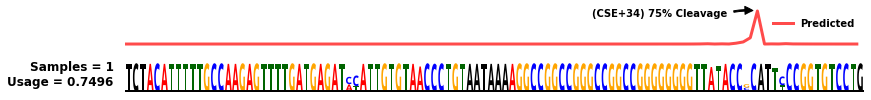

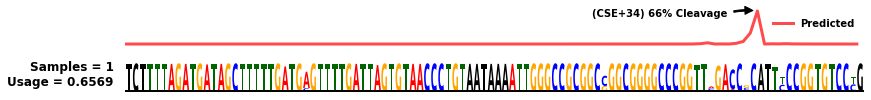

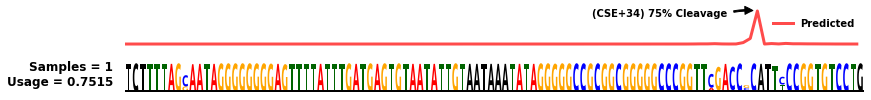

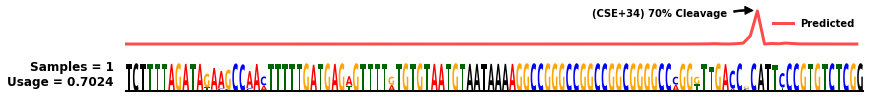

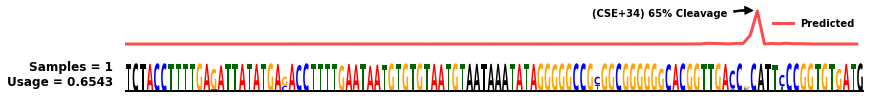

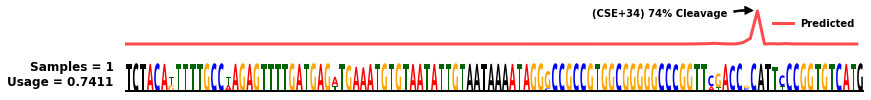

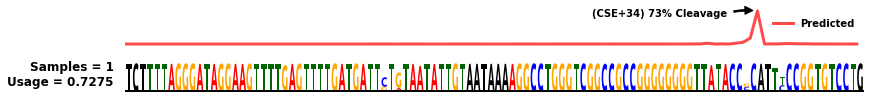

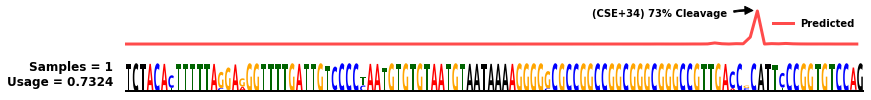

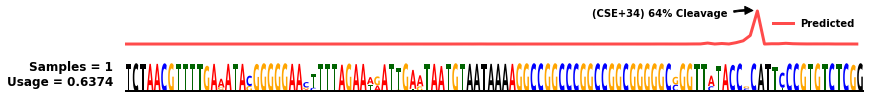

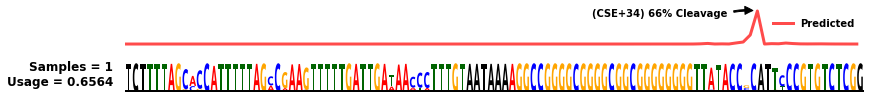

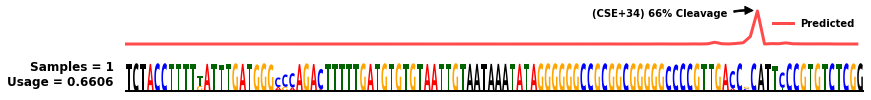

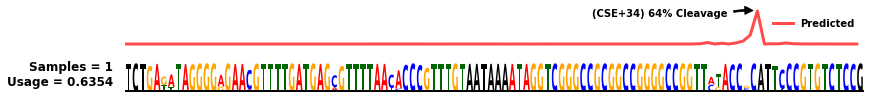

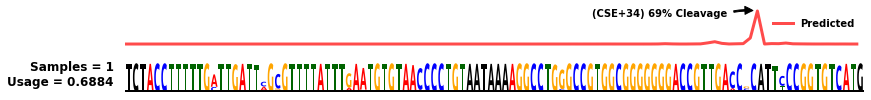

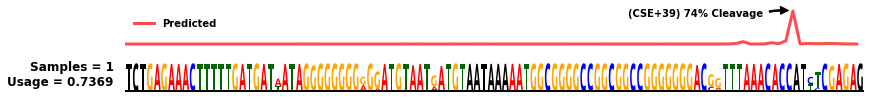

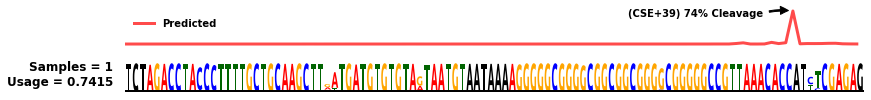

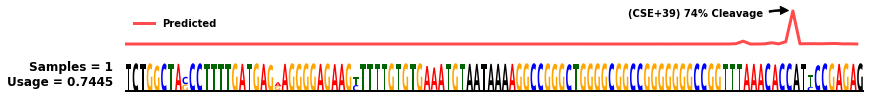

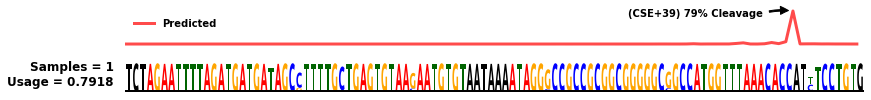

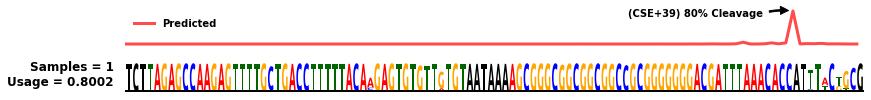

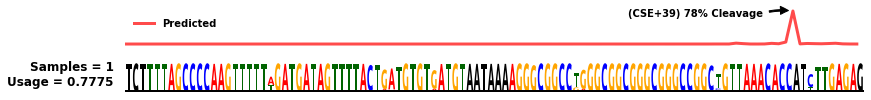

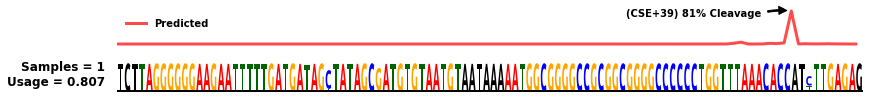

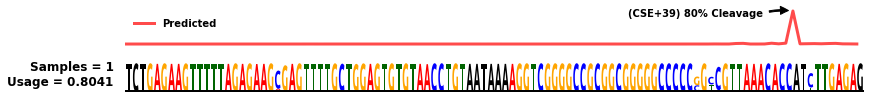

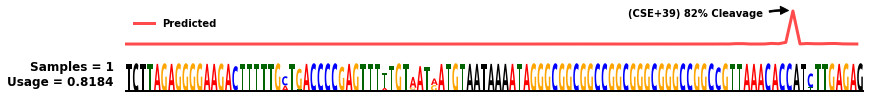

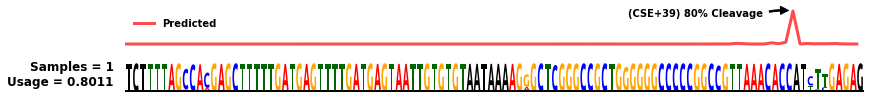

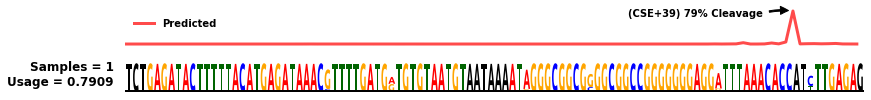

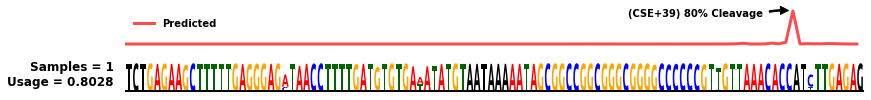

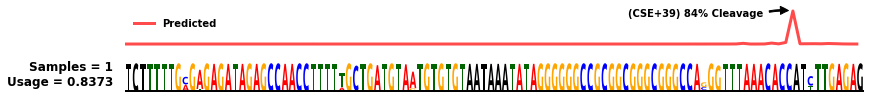

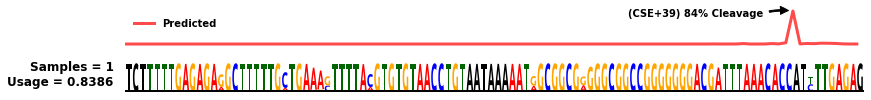

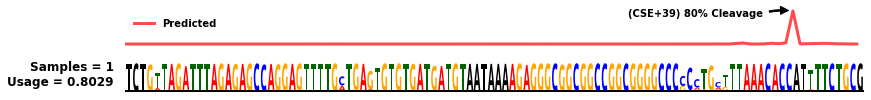

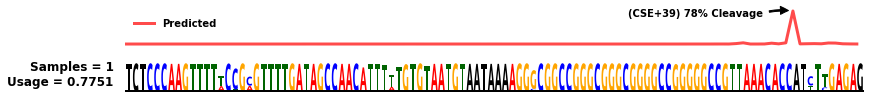

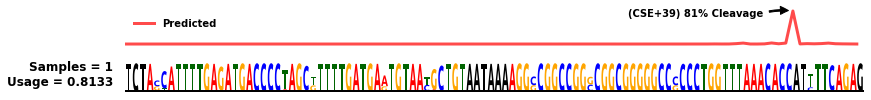

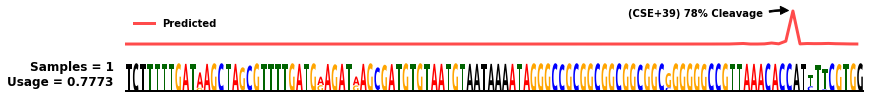

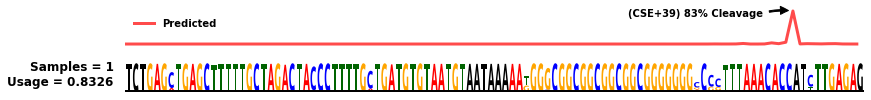

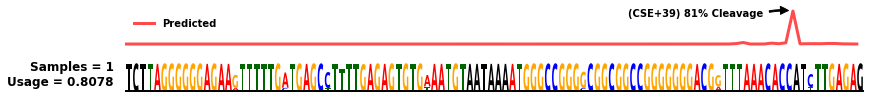

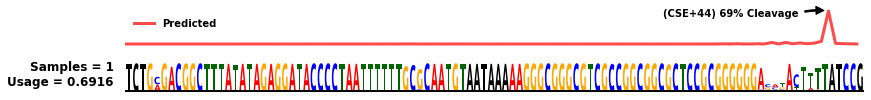

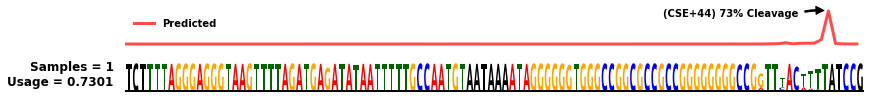

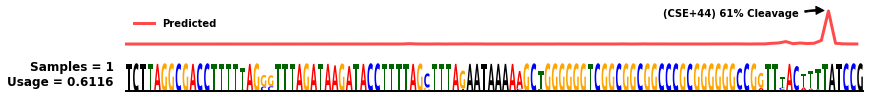

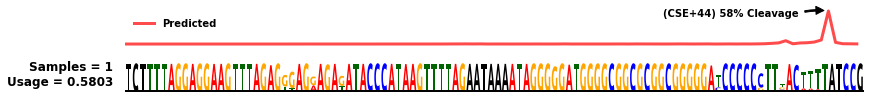

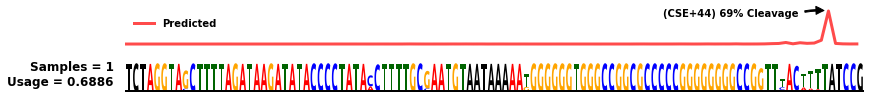

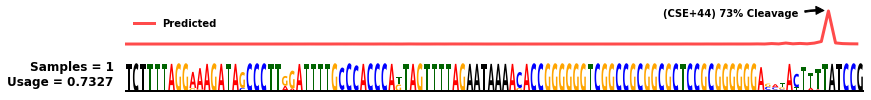

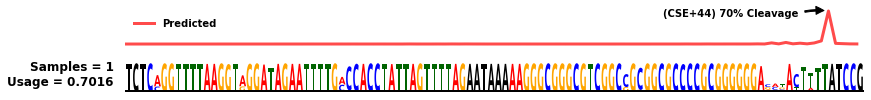

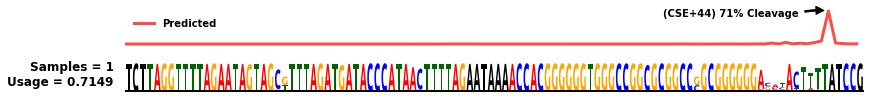

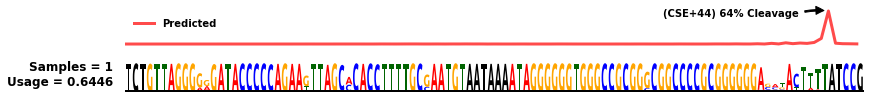

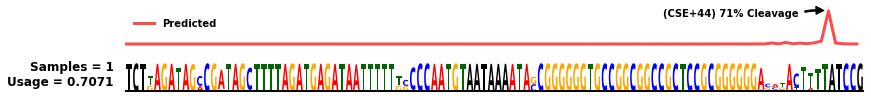

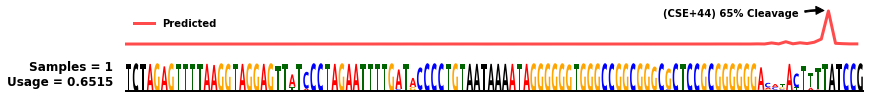

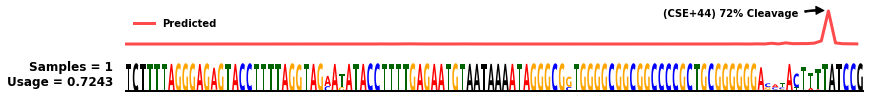

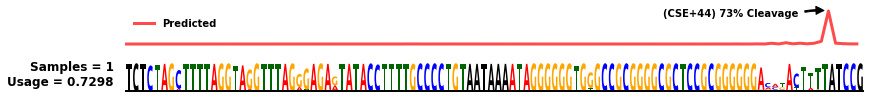

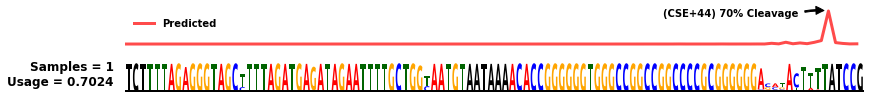

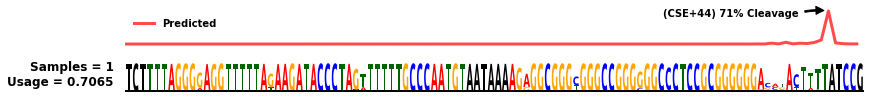

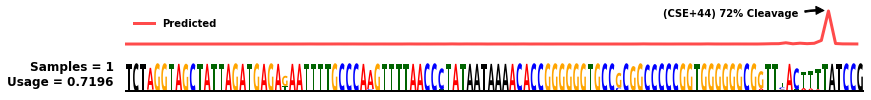

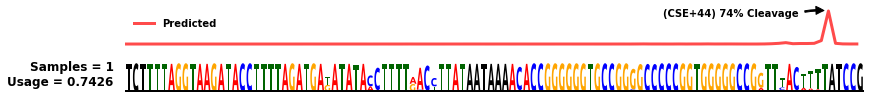

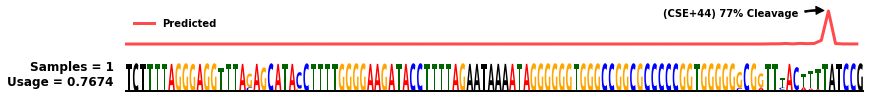

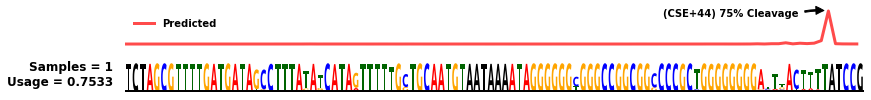

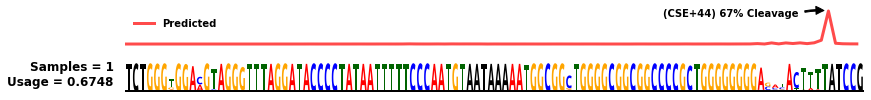

In [6]:
#Plot one PWM sequence logo per optimized objective (Experiment 'Punish A-runs')

for pwm_index in range(9 * 20) :
    
    sequence_template = sequence_templates[sequence_class[pwm_index, 0]]
    target_cut = cut_positions[sequence_class[pwm_index, 0]]
    
    pwm = np.expand_dims(optimized_pwm[pwm_index, :, :, 0], axis=0)
    cut = np.expand_dims(cut_pred[pwm_index, 0, :], axis=0)
    iso = np.expand_dims(np.sum(cut[:, target_cut:target_cut + 1], axis=-1), axis=-1)

    plot_seqprop_logo(pwm, iso, cut, annotate_peaks='max', sequence_template=sequence_template, figsize=(12.5, 1.5), width_ratios=[1, 8], logo_height=0.8, usage_unit='fraction', plot_start=70-49, plot_end=76+49, save_figs=False, fig_name='cleavage_genesis_target_cut_' + str(target_cut) + "_pwm_index_" + str(pwm_index), fig_dpi=150)


N Sequences = 10
Number of unique sequences = 10
Duplication rate = 0.0
N Sequences = 100
Number of unique sequences = 100
Duplication rate = 0.0
N Sequences = 1000
Number of unique sequences = 1000
Duplication rate = 0.0
N Sequences = 10000
Number of unique sequences = 10000
Duplication rate = 0.0
N Sequences = 100000
Number of unique sequences = 100000
Duplication rate = 0.0


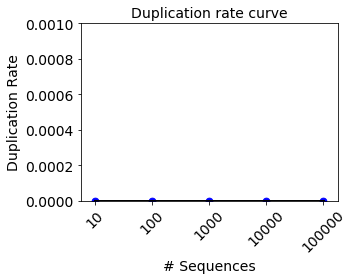

In [10]:

#Estimate duplication rates

def get_consensus_sequence(pwm) :
    consensus = ''
    
    for j in range(pwm.shape[0]) :
        nt_ix = np.argmax(pwm[j, :])
        
        if nt_ix == 0 :
            consensus += 'A'
        elif nt_ix == 1 :
            consensus += 'C'
        elif nt_ix == 2 :
            consensus += 'G'
        elif nt_ix == 3 :
            consensus += 'T'
    
    return consensus

f = plt.figure(figsize=(5, 4))

n_classes = 9
n_sequences_large_list = [10, 100, 1000, 10000, 100000]
dup_rates = []

save_figs = False

for n_sequences_large in n_sequences_large_list :
    n_sequences_ceil_large = int(n_sequences_large / 36) * 36 + 36

    print("N Sequences = " + str(n_sequences_large))

    sequence_class = np.array([np.random.randint(n_classes)] * n_sequences_ceil_large).reshape(-1, 1)

    noise_1 = np.random.uniform(-1, 1, (n_sequences_ceil_large, 100))
    noise_2 = np.random.uniform(-1, 1, (n_sequences_ceil_large, 100))

    pred_outputs = predictor.predict([sequence_class, noise_1, noise_2], batch_size=36)

    _, _, _, optimized_pwm_large, _, sampled_pwm_large, _, _, _, _, _, _, _ = pred_outputs

    onehots_large = sampled_pwm_large[:, 0, :, :, :]


    consensus_seqs_large = []

    for i in range(onehots_large.shape[0]) :
        consensus_seqs_large.append(get_consensus_sequence(onehots_large[i, :, :, 0]))

    consensus_seqs_large = np.array(consensus_seqs_large, dtype=np.object)

    #Sample first n_sequences
    onehots_large_kept = onehots_large[:n_sequences_large, :, :]
    consensus_large_seqs_kept = consensus_seqs_large[:n_sequences_large]

    n_unique_seqs_kept = len(np.unique(consensus_large_seqs_kept))

    print("Number of unique sequences = " + str(n_unique_seqs_kept))
    
    dup_rate = 1. - n_unique_seqs_kept / n_sequences_large
    dup_rates.append(dup_rate)
    
    print("Duplication rate = " + str(round(dup_rate, 4)))


plt.plot(np.arange(len(n_sequences_large_list)), dup_rates, linewidth=3, linestyle='-', color='black')
plt.scatter(np.arange(len(n_sequences_large_list)), dup_rates, c='blue', s=45)

plt.xlabel("# Sequences", fontsize=14)
plt.ylabel("Duplication Rate", fontsize=14)
plt.xticks(np.arange(len(n_sequences_large_list)), n_sequences_large_list, fontsize=14, rotation=45)
plt.yticks(fontsize=14)

plt.ylim(0, np.max(dup_rates) * 1.10 + 0.001)

plt.title("Duplication rate curve", fontsize=14)

plt.tight_layout()

if save_figs :
    plt.savefig("apa_cleavage_dup_rate_curve.eps")
    plt.savefig("apa_cleavage_dup_rate_curve.svg")
    plt.savefig("apa_cleavage_dup_rate_curve.png", transparent=True, dpi=150)

plt.show()


In [17]:
import scipy
import scipy.sparse as sp


n = 36 * 100

sequence_class = np.array([np.random.randint(n_classes)] * n).reshape(-1, 1)

noise_1 = np.random.uniform(-1, 1, (n, 100))
noise_2 = np.random.uniform(-1, 1, (n, 100))

pred_outputs = predictor.predict([sequence_class, noise_1, noise_2], batch_size=36)

_, _, _, optimized_pwm, _, sampled_pwm, _, _, _, _, _, _, _ = pred_outputs

onehots = sampled_pwm[:, 0, :, :, :]


#Evaluate Sequence diversity

def get_consensus_sequence(pwm) :
    consensus = ''
    
    for j in range(pwm.shape[0]) :
        nt_ix = np.argmax(pwm[j, :])
        
        if nt_ix == 0 :
            consensus += 'A'
        elif nt_ix == 1 :
            consensus += 'C'
        elif nt_ix == 2 :
            consensus += 'G'
        elif nt_ix == 3 :
            consensus += 'T'
    
    return consensus

n_sequences = 1000

consensus_seqs = []

for i in range(onehots.shape[0]) :
    consensus_seqs.append(get_consensus_sequence(onehots[i, :, :, 0]))

consensus_seqs = np.array(consensus_seqs, dtype=np.object)

#Sample first n_sequences
onehots_kept = onehots[:n_sequences, :, :]
consensus_seqs_kept = consensus_seqs[:n_sequences]

print("Number of unique sequences = " + str(len(np.unique(consensus_seqs_kept))))

#Calculate average/std nucleotide entropy

nt_entropies = []
for j in range(onehots_kept.shape[1]) :
    if sequence_templates[0][j] == 'N' :
        
        p_A = np.sum(onehots_kept[:, j, 0, 0]) / n_sequences
        p_C = np.sum(onehots_kept[:, j, 1, 0]) / n_sequences
        p_G = np.sum(onehots_kept[:, j, 2, 0]) / n_sequences
        p_T = np.sum(onehots_kept[:, j, 3, 0]) / n_sequences
        
        nt_entropy = 0
        if p_A * p_C * p_G * p_T > 0. :
            nt_entropy = - (p_A * np.log2(p_A) + p_C * np.log2(p_C) + p_G * np.log2(p_G) + p_T * np.log2(p_T))
        
        nt_entropies.append(nt_entropy)

nt_entropies = np.array(nt_entropies)

print("Mean NT Entropy = " + str(round(np.mean(nt_entropies), 4)))
print("Std NT Entropy = " + str(round(np.std(nt_entropies), 4)))


#Calculate hexamer entropies

hexamer_encoder = isol.NMerEncoder(n_mer_len=6, count_n_mers=True)

hexamers = isol.SparseBatchEncoder(encoder=hexamer_encoder)([x[20:128] for x in consensus_seqs_kept])

print(hexamers.shape)

hexamer_sum = np.ravel(hexamers.sum(axis=0))

hexamers_probs = hexamer_sum / np.sum(hexamer_sum)

n_nonzero_hexamers = len(np.nonzero(hexamer_sum > 0)[0])

print("Number of unique hexamers = " + str(n_nonzero_hexamers))


hexamer_entropy = -1. * np.sum(hexamers_probs[hexamer_sum > 0] * np.log2(hexamers_probs[hexamer_sum > 0]))

print("Hexamer Entropy = " + str(hexamer_entropy))


#Calculate average/std hexamer entropy

nonzero_index = np.nonzero(hexamer_sum > 0)[0]

hexamer_entropies = []
for j in range(n_nonzero_hexamers) :
    p_on = len(np.nonzero(hexamers[:, nonzero_index[j]] > 0)[0]) / hexamers.shape[0]
    p_off = 1. - p_on

    hexamer_entropy = 0
    if p_on * p_off > 0. :
        hexamer_entropy = -(p_on * np.log2(p_on) + p_off * np.log2(p_off))

    hexamer_entropies.append(hexamer_entropy)

hexamer_entropies = np.array(hexamer_entropies)

print("Mean Binary Hexamer Entropy = " + str(round(np.mean(hexamer_entropies), 4)))
print("Std Binary Hexamer Entropy = " + str(round(np.std(hexamer_entropies), 4)))


Number of unique sequences = 1000
Mean NT Entropy = 0.8703
Std NT Entropy = 0.7867
(1000, 4096)
Number of unique hexamers = 1727
Hexamer Entropy = 9.068884708802472
Mean Binary Hexamer Entropy = 0.2089
Std Binary Hexamer Entropy = 0.2554


In [18]:
#Helper function to get the conensus sequence from a PWM
def get_consensus_sequence(pwm) :
    consensus = ''
    
    for j in range(pwm.shape[0]) :
        nt_ix = np.argmax(pwm[j, :])
        
        if nt_ix == 0 :
            consensus += 'A'
        elif nt_ix == 1 :
            consensus += 'C'
        elif nt_ix == 2 :
            consensus += 'G'
        elif nt_ix == 3 :
            consensus += 'T'
    
    return consensus

n_classes = 9
n_sequences = 1000
n_sequences_ceil = int(n_sequences / 36) * 36 + 36

pwms = []
consensus_seqs = []
onehot_seqs = []
iso_preds = []
cut_preds = []
objectives = []

onehot_encoder = isol.OneHotEncoder(205)

for k in range(n_classes) :
    print('Predicting sequences for objective ' + str(k) + '...')
    
    sequence_class = np.tile(np.array([[k]]), (n_sequences_ceil, 1))
    
    noise_1 = np.random.uniform(-1, 1, (n_sequences_ceil, 100))
    noise_2 = np.random.uniform(-1, 1, (n_sequences_ceil, 100))
    
    pred_outputs = predictor.predict([sequence_class, noise_1, noise_2], batch_size=36)
    _, _, _, optimized_pwm, _, _, _, _, _, iso_pred, cut_pred, _, _ = pred_outputs

    optimized_pwm = np.expand_dims(optimized_pwm[:n_sequences, :, :, 0], axis=0)
    cut_pred = cut_pred[:n_sequences, 0, :]
    
    obj_ix = cut_positions[k]
    iso_pred = np.expand_dims(np.sum(cut_pred[:, obj_ix-1:obj_ix+2], axis=-1), axis=0)
    cut_pred = np.expand_dims(cut_pred, axis=0)
    
    pwms.append(optimized_pwm)
    iso_preds.append(iso_pred)
    cut_preds.append(cut_pred)
    
    consensus_seqs.append([])
    onehot_seqs.append([])
    for i in range(n_sequences) :
        consensus_seqs[k].append(get_consensus_sequence(optimized_pwm[0, i, :, :]))
        onehot_seqs[k].append(onehot_encoder(get_consensus_sequence(optimized_pwm[0, i, :, :])))
    
    consensus_seqs[k] = np.expand_dims(np.array(consensus_seqs[k], dtype=np.object), axis=0)
    onehot_seqs[k] = np.expand_dims(onehot_seqs[k], axis=0)
    
    objectives.append(np.zeros((1, n_sequences)) + k)

pwms = np.concatenate(pwms, axis=0)
iso_preds = np.concatenate(iso_preds, axis=0)
cut_preds = np.concatenate(cut_preds, axis=0)
consensus_seqs = np.concatenate(consensus_seqs, axis=0)
onehot_seqs = np.concatenate(onehot_seqs, axis=0)
objectives = np.concatenate(objectives, axis=0)

print('pwms.shape = ' + str(pwms.shape))
print('iso_preds.shape = ' + str(iso_preds.shape))
print('cut_preds.shape = ' + str(cut_preds.shape))
print('consensus_seqs.shape = ' + str(consensus_seqs.shape))
print('onehot_seqs.shape = ' + str(onehot_seqs.shape))
print('objectives.shape = ' + str(objectives.shape))

Predicting sequences for objective 0...
Predicting sequences for objective 1...
Predicting sequences for objective 2...
Predicting sequences for objective 3...
Predicting sequences for objective 4...
Predicting sequences for objective 5...
Predicting sequences for objective 6...
Predicting sequences for objective 7...
Predicting sequences for objective 8...
pwms.shape = (9, 1000, 205, 4)
iso_preds.shape = (9, 1000)
cut_preds.shape = (9, 1000, 206)
consensus_seqs.shape = (9, 1000)
onehot_seqs.shape = (9, 1000, 205, 4)
objectives.shape = (9, 1000)


In [19]:

flat_onehot_seqs = np.reshape(onehot_seqs, (n_classes * n_sequences, 205 * 4))
flat_objectives = np.ravel(objectives)

obj_poses = cut_positions

flat_labels = np.array(['CSE+' + str(obj_poses[int(k)] - 75) for k in flat_objectives.tolist()], dtype=np.object)

flat_onehot_seqs_opt = flat_onehot_seqs[:, 24*4:124*4]
flat_onehot_seqs_dse = flat_onehot_seqs[:, 75*4:124*4]


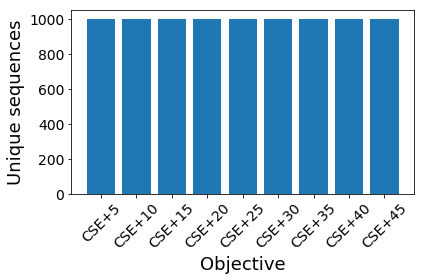

Mean Cut Log Odds (CSE+5) = 2.0981
Std Cut Log Odds (CSE+5) = 0.3425
Mean Cut Log Odds (CSE+10) = 3.1699
Std Cut Log Odds (CSE+10) = 0.4999
Mean Cut Log Odds (CSE+15) = 3.5382
Std Cut Log Odds (CSE+15) = 0.467
Mean Cut Log Odds (CSE+20) = 3.0305
Std Cut Log Odds (CSE+20) = 0.4574
Mean Cut Log Odds (CSE+25) = 2.9291
Std Cut Log Odds (CSE+25) = 0.3765
Mean Cut Log Odds (CSE+30) = 2.6425
Std Cut Log Odds (CSE+30) = 0.3897
Mean Cut Log Odds (CSE+35) = 1.7261
Std Cut Log Odds (CSE+35) = 0.3207
Mean Cut Log Odds (CSE+40) = 1.6062
Std Cut Log Odds (CSE+40) = 0.2851
Mean Cut Log Odds (CSE+45) = 1.3136
Std Cut Log Odds (CSE+45) = 0.239


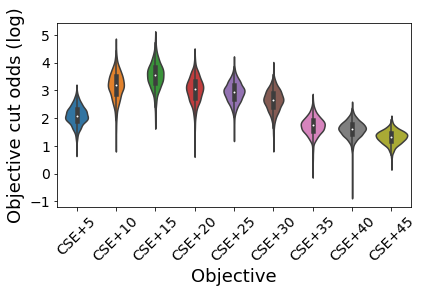

Avg pos R^2 = 0.9981, p = 0.0


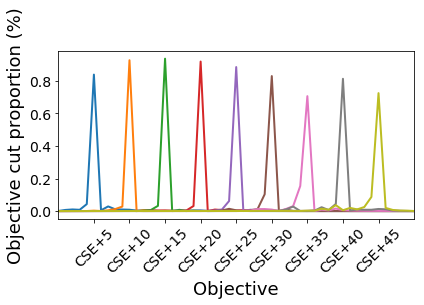

In [36]:
from scipy.stats import pearsonr
import seaborn as sns
#sns.set()

#Uniquely generated sequences per objective

unique_counts = np.array([len(np.unique(consensus_seqs[k, :])) for k in range(n_classes)])

f = plt.figure(figsize=(6, 4))

plt.bar(np.arange(n_classes), unique_counts)#, edgecolor='darkgrey', linewidth=2, color='black'

plt.xticks(np.arange(n_classes), ['CSE+' + str(obj_poses[int(k)] - 75) for k in range(n_classes)], fontsize=14, rotation=45)
plt.yticks(fontsize=14)

plt.xlabel('Objective', fontsize=18)
plt.ylabel('Unique sequences', fontsize=18)

plt.tight_layout()
plt.show()


#Objective cut log odds violin plot

save_figs = False

cut_logodds = [np.log(iso_preds[k, :] / (1.0 - iso_preds[k, :])) for k in range(n_classes)]

for k in range(n_classes) :
    print("Mean Cut Log Odds (CSE+" + str(obj_poses[int(k)] - 75) + ") = " + str(round(np.mean(cut_logodds[k]), 4)))
    print("Std Cut Log Odds (CSE+" + str(obj_poses[int(k)] - 75) + ") = " + str(round(np.std(cut_logodds[k]), 4)))

f = plt.figure(figsize=(6, 4))

sns.violinplot(data=cut_logodds)

plt.xticks(np.arange(n_classes), ['CSE+' + str(obj_poses[int(k)] - 75) for k in range(n_classes)], fontsize=14, rotation=45)
plt.yticks(fontsize=14)

plt.xlabel('Objective', fontsize=18)
plt.ylabel('Objective cut odds (log)', fontsize=18)

plt.tight_layout()

fig_name = 'cleavage_genesis_logodds_violin'

if save_figs :
    plt.savefig(fig_name + '.png', transparent=True, dpi=150)
    plt.savefig(fig_name + '.svg')
    plt.savefig(fig_name + '.eps')

plt.show()

#Average cut profile per objective
cut_preds_prox = cut_preds[:, :, :-1] / np.expand_dims(np.sum(cut_preds[:, :, :-1], axis=-1), axis=-1)
flat_cut_preds = np.reshape(cut_preds_prox, (n_classes * n_sequences, 205))

avg_cut_poses = np.sum(np.arange(205).reshape(1, -1) * flat_cut_preds, axis=-1)
targ_cut_poses = np.array([obj_poses[int(k)] for k in flat_objectives])

avg_pos_r, avg_pos_p_val = pearsonr(avg_cut_poses, targ_cut_poses)
avg_pos_r2 = avg_pos_r**2

print("Avg pos R^2 = " + str(round(avg_pos_r2, 4)) + ", p = " + str(round(avg_pos_p_val, 10)))



avgcut = np.mean(cut_preds[:, :, :-1] / np.expand_dims(np.sum(cut_preds[:, :, :-1], axis=-1), axis=-1), axis=1)

f = plt.figure(figsize=(6, 4))

for k in range(n_classes) :
    plt.plot(np.arange(205-75), avgcut[k, 75:], linewidth=2)

plt.xticks([obj_poses[int(k)] - 75 for k in range(n_classes)], ['CSE+' + str(obj_poses[int(k)] - 75) for k in range(n_classes)], fontsize=14, rotation=45)
plt.yticks(fontsize=14)

plt.xlim(0, 50)

plt.xlabel('Objective', fontsize=18)
plt.ylabel('Objective cut proportion (%)', fontsize=18)

plt.tight_layout()

fig_name = 'cleavage_genesis_average_cut'

if save_figs :
    plt.savefig(fig_name + '.png', transparent=True, dpi=150)
    plt.savefig(fig_name + '.svg')
    plt.savefig(fig_name + '.eps')

plt.show()

Starting PCA...
Done with PCA.
Starting tSNE...
Done with tSNE.


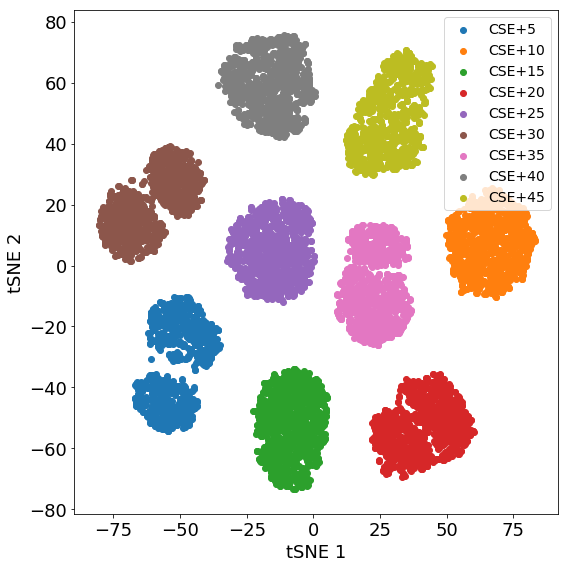

In [10]:
#PCA visualization, full sequence

save_figs = False

print('Starting PCA...')

pca = PCA(n_components=50)
flat_onehot_seqs_pca = pca.fit_transform(flat_onehot_seqs_opt)

print('Done with PCA.')

#tSNE visualization

print('Starting tSNE...')

tsne = TSNE(n_components=2)
flat_onehot_seqs_tsne = tsne.fit_transform(flat_onehot_seqs_pca)

print('Done with tSNE.')

f = plt.figure(figsize = (8, 8))

for label in ['CSE+5', 'CSE+10', 'CSE+15', 'CSE+20', 'CSE+25', 'CSE+30', 'CSE+35', 'CSE+40', 'CSE+45'] :
    plt.scatter(flat_onehot_seqs_tsne[flat_labels == label, 0], flat_onehot_seqs_tsne[flat_labels == label, 1], label=label)

plt.xlabel('tSNE 1', fontsize=18)
plt.ylabel('tSNE 2', fontsize=18)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=14)

plt.tight_layout()

fig_name = 'cleavage_genesis_tsne'

if save_figs :
    plt.savefig(fig_name + '.png', transparent=True, dpi=150)
    plt.savefig(fig_name + '.svg')
    plt.savefig(fig_name + '.eps')

plt.show()


Starting PCA...
Done with PCA.
Starting tSNE...
Done with tSNE.


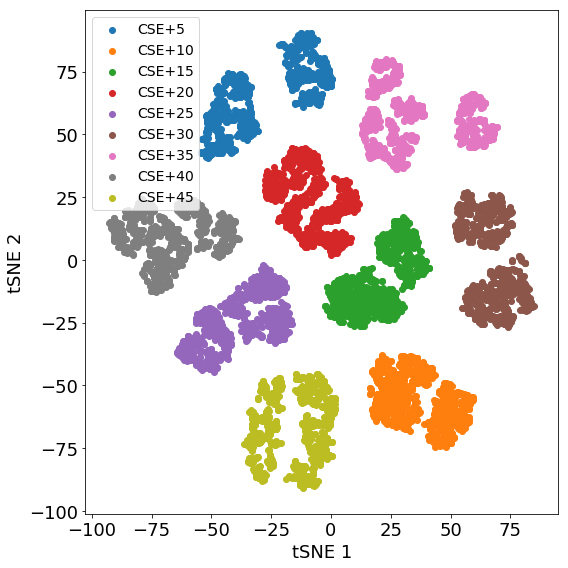

In [11]:
#PCA visualization, DSE only

save_figs = False

print('Starting PCA...')

pca = PCA(n_components=50)
flat_onehot_seqs_pca = pca.fit_transform(flat_onehot_seqs_dse)

print('Done with PCA.')

#tSNE visualization

print('Starting tSNE...')

tsne = TSNE(n_components=2)
flat_onehot_seqs_tsne = tsne.fit_transform(flat_onehot_seqs_pca)

print('Done with tSNE.')

f = plt.figure(figsize = (8, 8))

for label in ['CSE+5', 'CSE+10', 'CSE+15', 'CSE+20', 'CSE+25', 'CSE+30', 'CSE+35', 'CSE+40', 'CSE+45'] :
    plt.scatter(flat_onehot_seqs_tsne[flat_labels == label, 0], flat_onehot_seqs_tsne[flat_labels == label, 1], label=label)

plt.xlabel('tSNE 1', fontsize=18)
plt.ylabel('tSNE 2', fontsize=18)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=14)

plt.tight_layout()

fig_name = 'cleavage_genesis_tsne_dse_only'

if save_figs :
    plt.savefig(fig_name + '.png', transparent=True, dpi=150)
    plt.savefig(fig_name + '.svg')
    plt.savefig(fig_name + '.eps')

plt.show()


In [37]:
#Load designed MPRA data (Collapsed over experiment replicates)
seq_dict = isoio.load('~/aparent/data/prepared_data/apa_array_data/apa_array_data_master_seq')
print("n = " + str(len(seq_dict['array_df'])))
print('Avg read count (avg over barcodes) = ' + str(np.mean(seq_dict['array_df'].query("n_barcodes >= 2")['mean_total_count'])))
print('Pooled read count (pooled over barcodes) = ' + str(np.mean(seq_dict['array_df'].query("n_barcodes >= 2")['pooled_total_count'])))


n = 39833
Avg read count (avg over barcodes) = 431.92676310713546
Pooled read count (pooled over barcodes) = 3656.5562880452626


In [38]:
seq_df = seq_dict['array_df']
seq_cuts = seq_dict['pooled_cuts']

In [39]:

#Get observed cleavage count matrix
cut_true = np.concatenate([np.array(seq_cuts[:, 180 + 20: 180 + 205].todense()), np.array(seq_cuts[:, -1].todense()).reshape(-1, 1)], axis=-1)

#Add small pseudo count to true cuts
cut_true += 0.0005
cut_true = cut_true / np.sum(cut_true, axis=-1).reshape(-1, 1)

seq_df['cut_prob_true'] = [cut_true[i, :] for i in range(len(seq_df))]

In [40]:
unique_experiments = seq_df.query("experiment == 'max_cut'")['subexperiment'].unique()

seq_df_filtered = seq_df.query("mean_total_count >= 100 and n_barcodes >= 5")

cut_df_filtered = seq_df.query("experiment == 'max_cut' and mean_total_count >= 10").copy()

#Map and evaluate sequences
def eval_logloss(cut_prob, target_pos) :
    target = np.zeros(cut_prob.shape[0])
    target[target_pos] = 0.8
    target[target_pos - 1] = 0.10
    target[target_pos + 1] = 0.10
    
    ent = -np.dot(target, np.log((cut_prob + 0.001) / np.sum(cut_prob + 0.001)))
    
    return ent

start_pos = 58
end_pos = 108

cut_poses = np.arange(end_pos - start_pos) + (start_pos - 56)

true_cut_column = 'cut_prob_true'

avg_position_true = []
cut_probs_true = []
log_loss = []
for index, row in cut_df_filtered.iterrows() :
    
    cut_prob_true = np.ravel(row[true_cut_column])
    cut_prob_true = cut_prob_true[start_pos:end_pos] / np.sum(cut_prob_true[start_pos:end_pos])
    cut_probs_true.append(cut_prob_true)
    
    avg_pos_true = np.dot(cut_prob_true, (np.arange(cut_prob_true.shape[0]) + start_pos))
    avg_position_true.append(avg_pos_true)
    
    cut_pos_caught = False
    for cut_pos in [60, 65, 70, 75, 80, 85, 90, 95, 100] :
        if str(cut_pos) in row['subexperiment'] :            
            log_loss.append(eval_logloss(np.copy(cut_prob_true), cut_pos - 55 - (start_pos - 56)))
            
            cut_pos_caught = True
            break
    
    if not cut_pos_caught :
        log_loss.append(0)
    

cut_df_filtered['proxcut_prob_true'] = cut_probs_true
cut_df_filtered['avgpos_true'] = avg_position_true
cut_df_filtered['loss_logloss'] = log_loss

cut_snv_df_filtered = cut_df_filtered.query("variant == 'snv'").copy()
cut_df_filtered = cut_df_filtered.query("variant != 'snv'").copy()

print("Total number of Max Cut sequences = " + str(len(cut_df_filtered)))


df_human = seq_df_filtered.query("experiment == 'clinvar_wt' and variant == 'wt'")
human_cutprobs = np.array(df_human[true_cut_column].values.tolist())[:, start_pos:end_pos]
human_cutprobs = human_cutprobs / np.sum(human_cutprobs, axis=1).reshape(-1, 1)

human_cutprob = np.mean(human_cutprobs, axis=0)

objective_poses = [5, 10, 15, 20, 25, 30, 35, 40, 45]

seq_objective_df = cut_df_filtered.copy().reset_index()[['master_seq', 'experiment', 'subexperiment', 'variant', 'gene', 'cut_prob_true', 'avgpos_true']]

Total number of Max Cut sequences = 1274


In [41]:
#Map and collect array data

cut_nt = 'AT'
aruns_objective = ''#_aruns
ggcc_objective = ''#_GGCC
subexperiments = {
    0 : [cut_nt + aruns_objective + '_60', cut_nt + ggcc_objective + aruns_objective + '_ent_60'],#, cut_nt + aruns_objective + '_ent_60'
    1 : [cut_nt + aruns_objective + '_65', cut_nt + ggcc_objective + aruns_objective + '_ent_65'],#, cut_nt + aruns_objective + '_ent_65'],
    2 : [cut_nt + aruns_objective + '_70', cut_nt + ggcc_objective + aruns_objective + '_ent_70'],#, cut_nt + aruns_objective + '_ent_70'],
    3 : [cut_nt + aruns_objective + '_75', cut_nt + ggcc_objective + aruns_objective + '_ent_75'],#, cut_nt + aruns_objective + '_ent_75'],
    4 : [cut_nt + aruns_objective + '_80', cut_nt + ggcc_objective + aruns_objective + '_ent_80'],#, cut_nt + aruns_objective + '_ent_80'],
    5 : [cut_nt + ggcc_objective + aruns_objective + '_85', cut_nt + ggcc_objective + aruns_objective + '_ent_85'],#, cut_nt + ggcc_objective + aruns_objective + '_ent_85'],
    6 : [cut_nt + ggcc_objective + aruns_objective + '_90', cut_nt + ggcc_objective + aruns_objective + '_ent_90'],#, cut_nt + ggcc_objective + aruns_objective + '_ent_90'],
    7 : [cut_nt + ggcc_objective + aruns_objective + '_95', cut_nt + ggcc_objective + aruns_objective + '_ent_95'],#, cut_nt + ggcc_objective + aruns_objective + '_ent_95'],
    8 : [cut_nt + ggcc_objective + aruns_objective + '_100', cut_nt + ggcc_objective + aruns_objective + '_ent_100'],#, cut_nt + ggcc_objective + aruns_objective + '_ent_100'],
}

array_seqs = []
array_onehot_seqs = []
array_cut_preds = []
array_avg_poses = []
array_objectives = []
array_seqtypes = []

onehot_encoder = isol.OneHotEncoder(163)

for k in range(n_classes) :
    print('Collecting sequences for objective ' + str(k) + '...')
    
    sel_df = seq_objective_df.loc[seq_objective_df.subexperiment.isin(subexperiments[k])].copy()
    sel_df['master_seq'] = sel_df.master_seq.str.slice(1, 164)
    
    print('n_sequences = ' + str(len(sel_df)))
    
    array_seqs.append(list(sel_df.master_seq.values))
    array_seqs[k] = np.array(array_seqs[k], dtype=np.object)
    
    array_onehot_seqs.append([])
    for i in range(len(sel_df)) :
        array_onehot_seqs[k].append(onehot_encoder(array_seqs[k][i]))
    
    array_onehot_seqs[k] = np.array(array_onehot_seqs[k])
    
    cut_pred = np.array(list(sel_df['cut_prob_true'].values))
    array_cut_preds.append(cut_pred)
    
    avg_pos = np.array(list(sel_df['avgpos_true'].values))
    array_avg_poses.append(avg_pos)
    
    array_objectives.append(np.zeros(len(sel_df)) + k)
    
    array_seqtypes.append([])
    array_seqtypes[k] = np.array(list(sel_df['variant'].values), dtype=np.object)



n_sequences = 34
n_sequences = 32
n_sequences = 28
n_sequences = 33
n_sequences = 34
n_sequences = 34
n_sequences = 33
n_sequences = 34
n_sequences = 34


Accuracy = 257 / 296 = 0.87


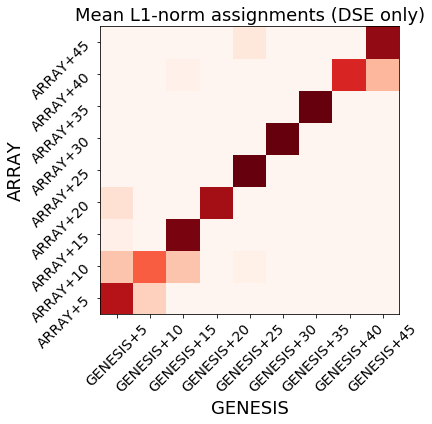

In [47]:
#One-hot L2-norm cluster centroid confusion matrix, DSE only

save_figs = False

cluster_means = np.mean(onehot_seqs[:, :, 76:125, :], axis=1).reshape(n_classes, -1)

l2_min_assignments = np.zeros((n_classes, n_classes))

n_correct = 0
n_tot = 0

for k in range(0, n_classes) :
    for i in range(0, array_onehot_seqs[k].shape[0]) :
        l2_distances = np.linalg.norm(cluster_means - array_onehot_seqs[k][i, 56:105, :].reshape(1, -1), ord=1, axis=-1)
        l2_min_ix = np.argmin(l2_distances)
        
        l2_min_assignments[k, l2_min_ix] += 1
        
        if l2_min_ix == k :
            n_correct += 1
            
        n_tot += 1


print("Accuracy = " + str(n_correct) + " / " + str(n_tot) + " = " + str(round(n_correct / n_tot, 2)))


l2_min_assignments = l2_min_assignments / np.sum(l2_min_assignments, axis=1).reshape(-1, 1)

f = plt.figure(figsize=(6, 6))

plt.pcolor(l2_min_assignments, cmap='Reds', vmin=0, vmax=1)

plt.xticks(np.arange(n_classes) + 0.5, ['GENESIS+' + str(obj_poses[int(k)] - 75) for k in range(n_classes)], fontsize=14, rotation=45)
plt.yticks(np.arange(n_classes) + 0.5, ['ARRAY+' + str(obj_poses[int(k)] - 75) for k in range(n_classes)], fontsize=14, rotation=45)

plt.title('Mean L1-norm assignments (DSE only)', fontsize=18)

plt.xlabel('GENESIS', fontsize=18)
plt.ylabel('ARRAY', fontsize=18)

plt.tight_layout()

fig_name = 'cleavage_genesis_array_knn'

if save_figs :
    plt.savefig(fig_name + '.png', transparent=True, dpi=150)
    plt.savefig(fig_name + '.svg')
    plt.savefig(fig_name + '.eps')

plt.show()



In [15]:
from scipy.stats import pearsonr

import seaborn as sns

from matplotlib import colors


flat_pwms_collection = []

for class_i in range(0, n_classes) :
    print("Target cut pos = " + str(obj_poses[class_i] - 75))
    
    flat_pwms = np.zeros((pwms.shape[1], 205))
    for i in range(pwms.shape[1]) :
        for j in range(205) :
            max_nt_ix = np.argmax(pwms[class_i, i, j, :])

            flat_pwms[i, j] = max_nt_ix + 1


    flat_pwms = flat_pwms[:20, 70-50: 76+50]#flat_pwms[:20, 70-45: 76+45]

    print(flat_pwms.shape)
    
    flat_pwms_collection.append(flat_pwms)


flat_pwms = np.concatenate(flat_pwms_collection[::-1], axis=0)



Target cut pos = 5
(20, 106)
Target cut pos = 10
(20, 106)
Target cut pos = 15
(20, 106)
Target cut pos = 20
(20, 106)
Target cut pos = 25
(20, 106)
Target cut pos = 30
(20, 106)
Target cut pos = 35
(20, 106)
Target cut pos = 40
(20, 106)
Target cut pos = 45
(20, 106)


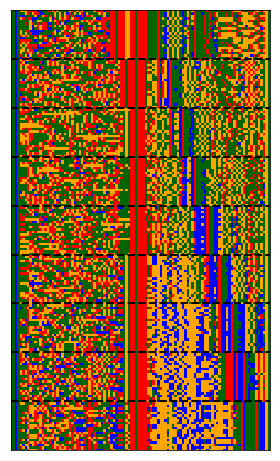

In [17]:
#Plot diversity grid

save_figs = False

cmap = colors.ListedColormap(['red', 'blue', 'orange', 'darkgreen'])
bounds=[0, 1, 2, 3, 4, 5]
norm = colors.BoundaryNorm(bounds, cmap.N)

w = flat_pwms.shape[1]

f = plt.figure(figsize=(4, 12))

plt.imshow(flat_pwms[:20 * n_classes, :], aspect='equal', interpolation='nearest', origin='lower', cmap=cmap, norm=norm)

for class_i in range(1, n_classes) :
    plt.plot([0, w], [class_i * 20, class_i * 20], linewidth=2, color='black', linestyle='--')

plt.xticks([], [])
plt.yticks([], [])

plt.xlim(0, w)
plt.ylim(0, 20 * n_classes)

plt.tight_layout()

if save_figs :
    plt.savefig('genesis_apa_cleavage_simple_image_seqs.png', transparent=True, dpi=150)
    plt.savefig('genesis_apa_cleavage_simple_image_seqs.svg')
    plt.savefig('genesis_apa_cleavage_simple_image_seqs.eps')

plt.show()